In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

from scipy import signal
import scipy.ndimage as im

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.7490434.datarmor0/parcels-502090/libparcels_random_713bf218-4340-48e9-ab38-961c4e9f1a4b.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=2
                 )
#
client = Client(cluster)

In [3]:
isel = dict(face=7)
sel = dict(i=slice(2700,2900), j=slice(2900,3100))#, i_g=slice(3000,3100), j_g=slice(3000,3100)) # North East Hawaii
#sel = dict(i=[3000,3010], j=[3000,3010], i_g=[3000,3010], j_g=[3000,3010]) # North East Hawaii

In [4]:
ds = xr.merge([xr.open_zarr(ut.work_data_dir+'rechunked/SSU.zarr'),xr.open_zarr(ut.work_data_dir+'rechunked/SSV.zarr')
              ])
grd = ut.load_grd()[['XC', 'YC', 'Depth']].persist()

In [5]:
ds['lon'] = 0*ds.face+grd.XC
ds['lat'] = 0*ds.face+grd.YC
ds = ds.drop(['i_g','j_g']).rename({'i_g':'i','j_g':'j'})#.drop(['i_g','j_g'])

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    

In [6]:
dsp = ds.isel(**isel).sel(**sel)

dsp = dsp.chunk({"time": -1}).persist() #,"i":10,"j":10
dsp

<xarray.Dataset>
Dimensions:  (i: 101, j: 101, time: 8784)
Coordinates:
  * i        (i) int64 2700 2702 2704 2706 2708 ... 2892 2894 2896 2898 2900
  * j        (j) int64 2900 2902 2904 2906 2908 ... 3092 3094 3096 3098 3100
    face     int64 7
  * time     (time) datetime64[ns] 2011-11-15 ... 2012-11-14T23:00:00
    XC       (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    CS       (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
Data variables:
    SSU      (time, j, i) float32 dask.array<chunksize=(8784, 86, 90), meta=np.ndarray>
    SSV      (time, j, i) float32 dask.array<chunksize=(8784, 86, 90), meta=np.ndarray>
    lon      (j, i) float64 dask.array<chunksize=(101, 101), meta=np.ndarray>
    lat      (j, i) float64 dask.array<chunksize=(101, 101), meta=np.ndarray>

In [7]:
dsp['zonal_velocity'] = dsp['SSU']*dsp.CS - dsp['SSV']*dsp.SN
dsp['meridional_velocity'] =  dsp['SSU']*dsp.SN + dsp['SSV']*dsp.CS
dsp = dsp.assign_coords({'lon':dsp.lon,'lat':dsp.lat})
dsp = dsp.drop(['SSU','SSV']).persist()


### Lagrangian

In [8]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'
parcels_index = 'time'

# choose to select time indexed data for now
p = pa.parcels_output(root_dir+run_name, parquets=[parcels_index])
df = p[parcels_index]
df = pa.degs2ms(df)
df.head()

trajectory        lat         lon    z  zonal_velocity  \
time                                                                 
2011-11-15    39000000  57.835732 -178.867081  0.0             0.0   
2011-11-15    39000001  58.429878 -178.871994  0.0             0.0   
2011-11-15    39000002  59.018066 -178.879623  0.0             0.0   
2011-11-15    39000003  59.600288 -178.890015  0.0             0.0   
2011-11-15    39000004  60.176525 -178.903275  0.0             0.0   

            meridional_velocity  sea_level  temperature  salinity  
time                                                               
2011-11-15                  0.0        0.0          0.0       0.0  
2011-11-15                  0.0        0.0          0.0       0.0  
2011-11-15                  0.0        0.0          0.0       0.0  
2011-11-15                  0.0        0.0          0.0       0.0  
2011-11-15                  0.0        0.0          0.0       0.0

In [9]:
lonmin,lonmax,latmin,latmax = dsp.lon.min().values,dsp.lon.max().values,dsp.lat.min().values,dsp.lat.max().values

In [10]:
# extract relevant trajectory indices
bbox=[lonmin,lonmax,latmin,latmax]
_df = df[ (df.lon>=bbox[0])
        &(df.lon<=bbox[1])
        &(df.lat>=bbox[2])
        &(df.lat<=bbox[3])
       ]
traj = _df.drop_duplicates(subset=["trajectory"]).compute()["trajectory"]
#traj = _df.index.drop_duplicates(keep='first').compute()#["index"]

df_selected = df[df.trajectory.isin(traj)]

In [13]:
lon,lat = df_selected.lon.values.compute(),df_selected.lat.values.compute()
df_zon_vel = df_selected.zonal_velocity.values.compute()

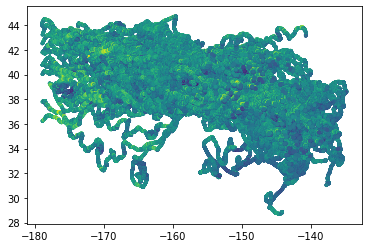

In [14]:
plt.scatter(lon,lat,c=df_zon_vel,s=6)

In [11]:
i=traj[10:15]
dfi = df_selected[df_selected.trajectory.isin(i)]
dfi = dfi.drop_duplicates('zonal_velocity').persist()

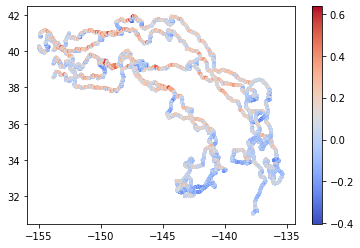

In [12]:
cs = plt.scatter(dfi.lon.compute(),dfi.lat.compute(),c = dfi.zonal_velocity.compute(),s=5,cmap='coolwarm')#.scatter(x='lon',y='lat',c='zonal_velocity',s=5,cmap='RdBu_r')
plt.colorbar(cs)
#plt.scatter(dfi.lon.values.compute(),dfi.lat.values.compute(),s=6,c=time)

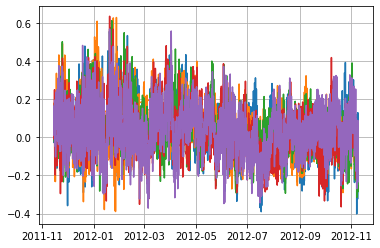

In [13]:
for ii in i:
    plt.plot(dfi[dfi.trajectory==ii].zonal_velocity.compute())
plt.grid()

In [11]:
def convolve(x, h=None, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    """
    #x_f = im.convolve1d(x, h, axis=1, mode='constant')
    x_f = signal.filtfilt(h, [1], x, axis=-1,padlen=0)#
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f
    
def filt_L(v, h,columns, hilbert=False):
    vc = v.copy()
    for V in columns:
        vc[V+'_hat'] = convolve(vc[V],h,hilbert=hilbert)
    time = np.arange(0,vc.index.size*dt,dt)#.compute()
    exp = np.exp(-1j*omega*2*np.pi*time)
    for V in columns:
        vc[V+'_demodulated'] = vc[V+'_hat']*exp
    #output_dtype = complex if hilbert else float
    #gufunc_kwargs = dict(output_sizes={'time': len(v.time)})
    return vc#xr.apply_ufunc(convolve, v, kwargs={'h': h, 'hilbert': hilbert},
            #        dask='parallelized', output_dtypes=[output_dtype],
            #       input_core_dims=[['time']],
            #        output_core_dims=[['time']],
            #       dask_gufunc_kwargs = gufunc_kwargs,
            #            )




In [12]:
dt = 1/24 # in days

tidal_omega = sp.get_tidal_frequencies("M2", "K1")
omega, domega, name = tidal_omega["M2"], .4, "semidiurnal"

h = sp.generate_filter(omega, T=10, dt=dt, bandwidth=domega, normalized_bandwidth=None)
h_hat, w = sp.filter_response(h, dt=dt)

In [13]:
#h = H.sel(T_window=20,bandwidth=0.1).dropna('time')
test_filter = dfi.groupby('trajectory').apply(filt_L,h,['zonal_velocity','meridional_velocity']).persist()

NameError: name 'dfi' is not defined

In [17]:

test_filter = test_filter.drop(columns=['trajectory'])

In [18]:
test_filter = test_filter.repartition(npartitions=10).persist()#.head()

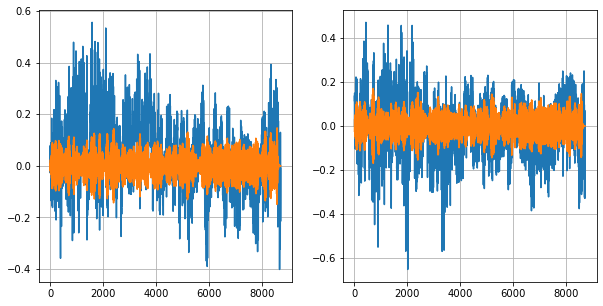

In [19]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
for v ,ax in zip(['zonal_velocity','meridional_velocity'],axs):
    ax.plot(test_filter.loc[(37000596)][v].values.compute())
    ax.plot(test_filter.loc[(37000596)][v+'_hat'].values.compute())
    ax.grid()

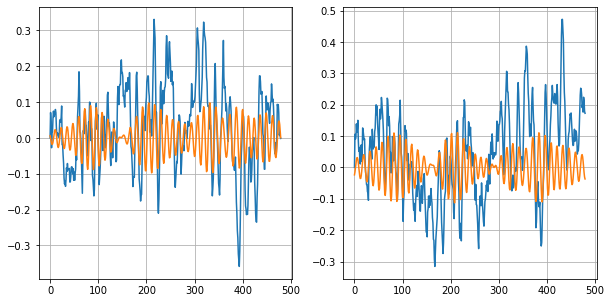

In [20]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
for v ,ax in zip(['zonal_velocity','meridional_velocity'],axs):
    ax.plot(test_filter.loc[(37000596)][v].values.compute()[:20*24])
    ax.plot(test_filter.loc[(37000596)][v+'_hat'].values.compute()[:20*24])
    ax.grid()

In [21]:
test_filter['lon'] = (test_filter['lon']+180)%360 - 180
lon_bins = np.arange(test_filter.lon.min().compute(),test_filter.lon.max().compute(),1)
lat_bins = np.arange(test_filter.lat.min().compute(),test_filter.lat.max().compute(),1)
test_filter['lon_cut'] = test_filter.lon.map_partitions(pd.cut, lon_bins)
test_filter['lat_cut'] = test_filter.lat.map_partitions(pd.cut, lat_bins)

In [22]:
filter_mean = test_filter.groupby(['lon_cut','lat_cut']).mean().compute()#.zonal_velocity.plot(x='lon_cut',y='lat_cut')
filter_mean = pa.add_geodata(filter_mean)

In [23]:
#means = pa.add_geodata(means)
#count['density'] = count['count']/count['area']

ds_mean = (filter_mean
     # .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

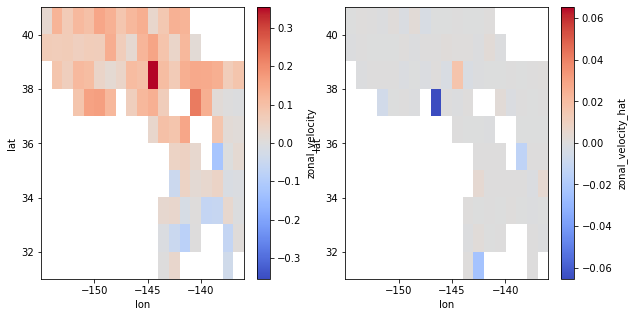

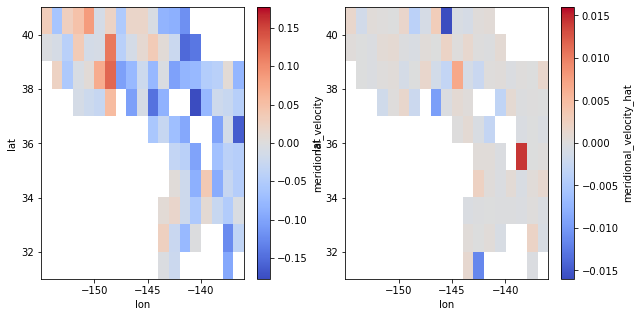

In [24]:
for v in ['zonal_velocity','meridional_velocity']:
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    ds_mean[v].plot(y='lat',ax=ax[0],cmap='coolwarm')
    ds_mean[v+'_hat'].plot(y='lat',ax=ax[1],cmap='coolwarm')

In [14]:
df_selected = df_selected.drop_duplicates(subset = "zonal_velocity")
df_filtered = df_selected.groupby('trajectory').apply(filt_L,h,['zonal_velocity','meridional_velocity'],hilbert=True).persist()
df_filtered = df_filtered.repartition(npartitions=10).persist()

<ipython-input-14-4c751e5334de>:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_filtered = df_selected.groupby('trajectory').apply(filt_L,h,['zonal_velocity','meridional_velocity'],hilbert=True).persist()


In [26]:
time = np.arange(0,dsp.time.size,dt)
exp = np.exp(-1j*omega*np.pi*2*time)
for v in ['zonal_velocity','meridional_velocity']:
    df_filtered[v+'_hat'+'_real'] = df_filtered[v+'_hat'].apply(lambda x : np.real(x),meta=(v+'_hat', 'float64'))
    df_filtered[v+'_hat'+'_imag'] = df_filtered[v+'_hat'].apply(lambda x : np.imag(x),meta=(v+'_hat', 'float64'))
    df_filtered[v+'_hat'+'_abs'] = df_filtered[v+'_hat'].apply(lambda x : np.abs(x),meta=(v+'_hat', 'float64'))
#    df_filtered[v+'_demodulated'] = df_filtered[v+'_hat'].apply(lambda x : x*exp,meta=(v+'_demodulated', 'complex128'))
df_filtered = df_filtered.persist()

In [27]:
df_filtered = df_filtered.drop(columns='trajectory').reset_index().set_index('time').persist()

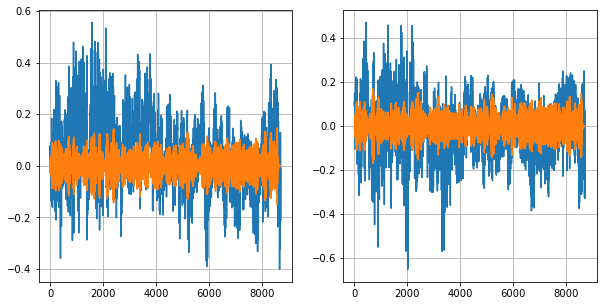

In [28]:
df_test = df_filtered[df_filtered.trajectory==37000596].compute()
fig,axs = plt.subplots(1,2,figsize=(10,5))
for v ,ax in zip(['zonal_velocity','meridional_velocity'],axs):
    ax.plot(df_test[v].values)
    ax.plot(df_test[v+'_hat_real'].values)
    ax.grid()

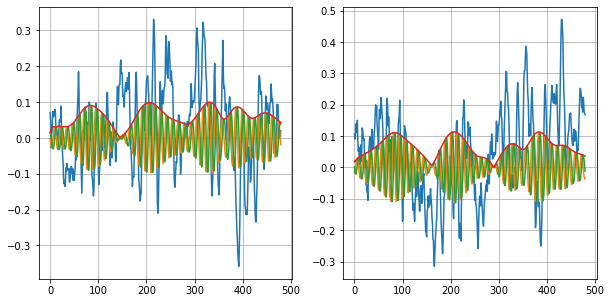

In [29]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
for v ,ax in zip(['zonal_velocity','meridional_velocity'],axs):
    ax.plot(df_test[v][:20*24].values)
    ax.plot(df_test[v+'_hat_real'].values[:20*24])
    ax.plot(df_test[v+'_hat_imag'].values[:20*24])
    ax.plot(df_test[v+'_hat_abs'].values[:20*24])
    ax.grid()

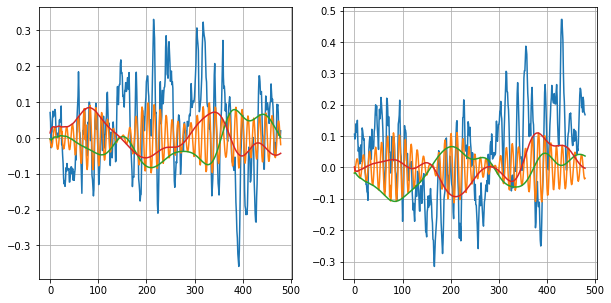

In [30]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
for v ,ax in zip(['zonal_velocity','meridional_velocity'],axs):
    ax.plot(df_test[v][:20*24].values)
    ax.plot(df_test[v+'_hat_real'].values[:20*24])
    ax.plot(np.real(df_test[v+'_demodulated'].values[:20*24]))
    ax.plot(np.imag(df_test[v+'_demodulated'].values[:20*24]))
    ax.grid()

In [36]:
df_filtered['lon'] = (df_filtered['lon']+180)%360 - 180
lon_bins = np.arange(df_filtered.lon.min().compute(),df_filtered.lon.max().compute(),0.3)
lat_bins = np.arange(df_filtered.lat.min().compute(),df_filtered.lat.max().compute(),0.3)
df_filtered['lon_cut'] = df_filtered['lon'].map_partitions(pd.cut, lon_bins)
df_filtered['lat_cut'] = df_filtered['lat'].map_partitions(pd.cut, lat_bins)

In [37]:
df_filtered = df_filtered.persist()

In [38]:
filter_mean = df_filtered.groupby(['lon_cut','lat_cut']).mean().compute()
#filter_mean = pa.add_geodata(filter_mean)

In [39]:
filter_mean = pa.add_geodata(filter_mean)
ds_mean = (filter_mean
     # .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

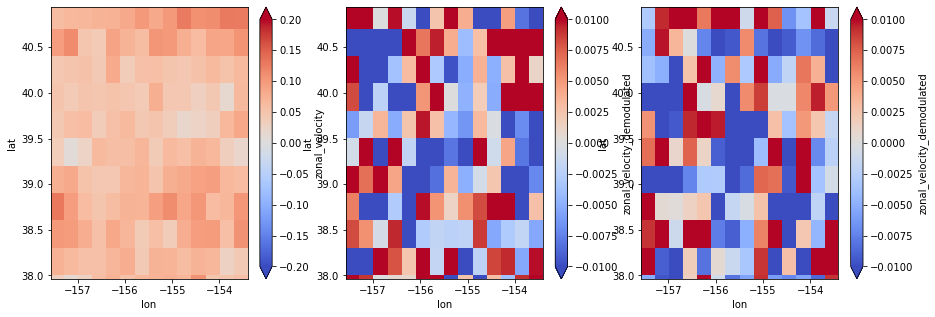

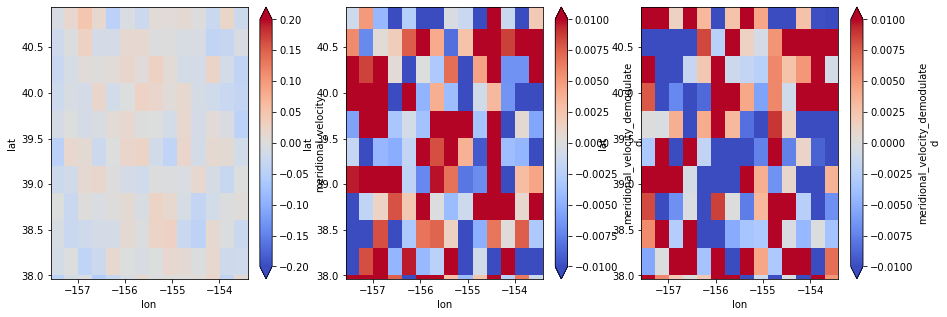

In [40]:
for v in ['zonal_velocity','meridional_velocity']:
    fig,ax = plt.subplots(1,3,figsize=(15,5))
    ds_mean[v].plot(y='lat',ax=ax[0],cmap='coolwarm',vmax=0.2)
    ds_mean[v+'_demodulated'].real.plot(y='lat',ax=ax[1],cmap='coolwarm',vmax=0.01)
    ds_mean[v+'_demodulated'].imag.plot(y='lat',ax=ax[2],cmap='coolwarm',vmax=0.01)
    for a in ax:
        a.set_ylim(dsp.lat.min(),dsp.lat.max())
        a.set_xlim(dsp.lon.min(),dsp.lon.max())
#    ax[1].set_ylim(dsp.lat.min(),dsp.lat.max())
#    ax[1].set_xlim(dsp.lon.min(),dsp.lon.max())

### Sensitivity to filter parameters

In [13]:
dt = 1/24 # in days

tidal_omega = sp.get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
#omega = (omega_M2+omega_S2+omega_N2+omega_K2)/4#(omega_M2+omega_S2)/2
omega = (omega_M2+omega_S2)/2
T_window,bandwidths = [10,20,30],[0.01,0.05,0.1,0.2,0.3,0.4]

In [14]:
H = xr.combine_nested([[xr.DataArray(sp.generate_filter(omega, T=T, dt=dt, bandwidth=dband, normalized_bandwidth=None),
             dims=['time'],coords={'time':np.arange(0,sp.generate_filter(omega, T=T, dt=dt, bandwidth=dband, normalized_bandwidth=None).size)*dt}) for T in T_window
                       ] for dband in bandwidths],concat_dim=['bandwidth','T_window'])
                     # coords={'time':np.arange(0,sp.generate_filter(omega, T=T, dt=dt, bandwidth=dband, normalized_bandwidth=None).size)*dt,'T_window':T_window,'bandwidth':bandwidths})

H = H.assign_coords({'T_window':T_window,'bandwidth':[b*2 for b in bandwidths]})
H
#xr.concat([xr.DataArraysp.generate_filter(omega, T=T, dt=dt, bandwidth=domega, normalized_bandwidth=None) for T in [10,20,30]],dim='T_window')

<xarray.DataArray (T_window: 3, bandwidth: 6, time: 720)>
array([[[ 3.02170262e-04, -3.21304853e-04, -8.67559700e-04, ...,
                     nan,             nan,             nan],
        [ 2.08850503e-04, -2.23850145e-04, -6.09190679e-04, ...,
                     nan,             nan,             nan],
        [ 1.63576738e-06, -5.25944417e-06, -2.38525523e-05, ...,
                     nan,             nan,             nan],
        [-2.74495051e-06,  8.81972567e-06,  3.99442419e-05, ...,
                     nan,             nan,             nan],
        [ 4.12505298e-06, -1.32389524e-05, -5.98215982e-05, ...,
                     nan,             nan,             nan],
        [-5.52368500e-06,  1.76993557e-05,  7.97197600e-05, ...,
                     nan,             nan,             nan]],

       [[-4.25028730e-04, -5.68055610e-04, -5.64571747e-04, ...,
                     nan,             nan,             nan],
        [-1.20013764e-06, -4.82918277e-06, -8.02755602e-06, ...,
                     nan,             nan,             nan],
        [ 2.01632231e-06,  8.11200330e-06,  1.34799709e-05, ...,
                     nan,             nan,             nan],
        [ 4.05847544e-06,  1.63167380e-05,  2.70768585e-05, ...,
                     nan,             nan,             nan],
        [ 6.08500985e-06,  2.44362879e-05,  4.04580973e-05, ...,
                     nan,             nan,             nan],
        [ 8.10833772e-06,  3.25094963e-05,  5.36518369e-05, ...,
                     nan,             nan,             nan]],

       [[-3.45315610e-04, -2.46889701e-04, -8.42330277e-05, ...,
         -8.42330277e-05, -2.46889701e-04, -3.45315610e-04],
        [ 1.37625770e-04,  9.85695392e-05,  3.36828237e-05, ...,
          3.36828237e-05,  9.85695392e-05,  1.37625770e-04],
        [-1.76419646e-06, -3.79041150e-06, -2.15849608e-06, ...,
         -2.15849608e-06, -3.79041150e-06, -1.76419646e-06],
        [ 3.54267630e-06,  7.60629457e-06,  4.32555803e-06, ...,
          4.32555803e-06,  7.60629457e-06,  3.54267630e-06],
        [-5.29250778e-06, -1.13502834e-05, -6.43992770e-06, ...,
         -6.43992770e-06, -1.13502834e-05, -5.29250778e-06],
        [ 7.07605234e-06,  1.51509791e-05,  8.56878255e-06, ...,
          8.56878255e-06,  1.51509791e-05,  7.07605234e-06]]])
Coordinates:
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 29.88 29.92 29.96
  * T_window   (T_window) int64 10 20 30
  * bandwidth  (bandwidth) float64 0.02 0.1 0.2 0.4 0.6 0.8

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


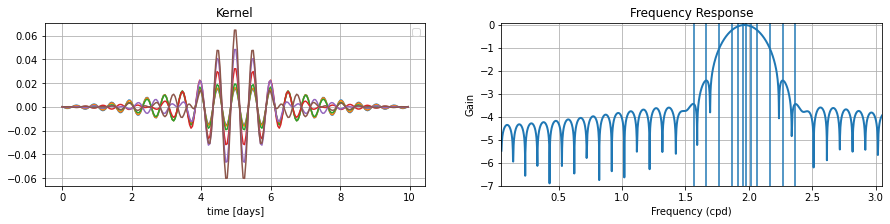

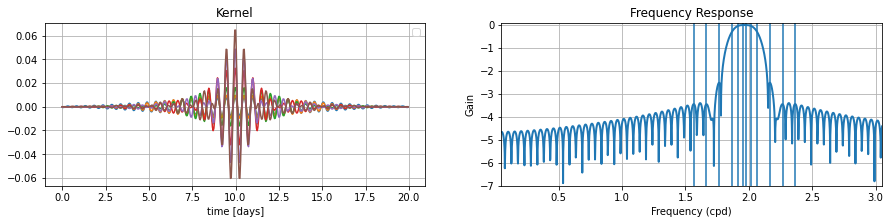

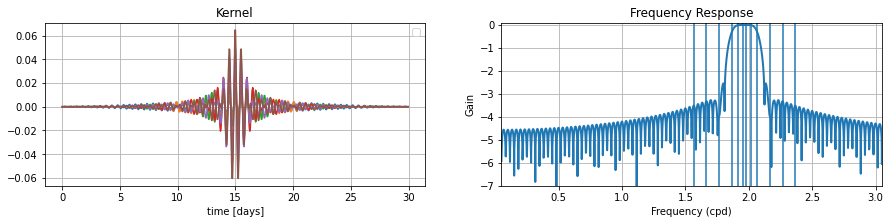

In [15]:
domega=0.2
for h in H.T_window:
    h_hat, w = sp.filter_response(H.sel(T_window=h,bandwidth=domega).dropna(dim='time'), dt=dt)
    fig, axes = plt.subplots(1,2, figsize=(15,3))
    ax = axes[0]
    #t = np.arange(0, h.size)*dt
    H.sel(T_window=h).plot(ax=ax,hue='bandwidth')
    ax.grid()
    ax.set_xlabel('time [days]')
    ax.set_title('Kernel')
    ax.legend()

    ax = axes[1]
    ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
    for d in H.bandwidth:
        ax.axvline(omega-d/2)#, color='k')
        ax.axvline(omega+d/2)#, color='k')
    ax.set_xlabel('Frequency (cpd)')
    ax.set_ylabel('Gain')
    ax.set_title('Frequency Response')
    ax.set_ylim(-0.05, 1.05)
    ax.set_ylim(-7, 0.1)
    ax.set_xlim(0.05, 3.05)
    ax.grid(True)
    #H.plot.line(hue='T_window')

In [16]:
df_selected = df_selected.drop_duplicates(subset='zonal_velocity')
#df_selected = df_selected.drop(columns=[v+'_interp' for v in ['SST','SSS','SSU','SSV','Eta']])
#df_selected = df_selected.drop(columns=['temperature','salinity','z'])    
df_selected = df_selected.persist()
#df_filtered = df_selected.groupby('trajectory').apply(filt_L,h,['zonal_velocity','meridional_velocity'],hilbert=True).persist()

In [17]:
t = {}
for Tw in T_window:
    for dband in H.bandwidth:
        h = H.sel(T_window=Tw,bandwidth=dband).dropna('time').values
        t['T%sband%s'%(Tw,dband.values)] = df_selected.groupby('trajectory').apply(filt_L,h,['zonal_velocity','meridional_velocity'],hilbert=True)
        t['T%sband%s'%(Tw,dband.values)] = t['T%sband%s'%(Tw,dband.values)].drop(columns='trajectory').reset_index().set_index('time')
#t = filt_Lcombined(df_selected,H,20,0.2)

<ipython-input-17-d2e1b0d0f7ef>:5: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  t['T%sband%s'%(Tw,dband.values)] = df_selected.groupby('trajectory').apply(filt_L,h,['zonal_velocity','meridional_velocity'],hilbert=True)
<ipython-input-17-d2e1b0d0f7ef>:5: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  t['T%sband%s'%(Tw,dband.values)] = df_selected.groupby('trajectory').apply(filt_L,h,['zonal_velocity','meridional_velocity'],hilbert=True)
<ipython-input-17-d2e1b0d0f7ef>:5: UserWarning: `meta` is not specified, inferred 

In [53]:
ti = {}
for Tw in T_window:
    for dband in H.bandwidth.values:
        ti['T'+str(Tw)+'band'+str(dband)] = t['T'+str(Tw)+'band'+str(dband)][t['T'+str(Tw)+'band'+str(dband)].trajectory==37000596].compute()

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [ ]:

for v in ['zonal_velocity','meridional_velocity']:
    for Tw in T_window:
    fig,axs = plt.subplots(1,len(bandwidths),figsize=(6*len(bandwidths),6),sharey=True)
    for dband,ax in zip(H.bandwidth,axs):
        ti['T'+str(Tw)+'band'+str(dband)][v].isel(time=slice(0,20*24)).sel(bandwidth=dband,T_window=10).plot(ax=ax,c='k')
        np.real(dsi[v+'_hat']).isel(time=slice(0,20*24)).sel(bandwidth=dband).plot(ax=ax,x='time',hue='T_window')
        np.abs(dsi[v+'_hat']).isel(time=slice(0,20*24)).sel(bandwidth=dband).plot(ax=ax,x='time',hue='T_window')
        ax.grid();ax.set_ylim(-0.25,0.45);ax.set_ylabel('')
    axs[0].set_ylabel('%s %s'%(v.split('_')[0],v.split('_')[1]))

#### Alternative : convert to xarray dataset to combine all window length and bandwidth

In [46]:
def filt_Lcombined(df_selected,H,Tw,dband):
    h = H.sel(T_window=Tw,bandwidth=dband).dropna('time').values
    _df = df_selected.groupby('trajectory').apply(filt_L,h,['zonal_velocity','meridional_velocity'],hilbert=True)
    _df = _df.drop(columns='trajectory').reset_index().set_index('time').persist()
    #_df = _df.groupby(_df.index).apply(demodulation,['zonal_velocity','meridional_velocity']).persist()
    #_df = _df.drop(columns='trajectory').reset_index().set_index('time').persist()
    _ds = xr.Dataset.from_dataframe(_df)
    _ds = _ds.assign_coords({'trajectory':_ds.trajectory,'lon':_ds.lon,'lat':_ds.lat})
    return _ds

In [47]:
_ds = xr.combine_nested([[filt_Lcombined(df_selected,H,Tw,2*dband) for Tw in T_window] for dband in bandwidths],concat_dim=['bandwidth','T_window'])
_ds = _ds.assign_coords({'T_window':T_window,'bandwidth':[2*d for d in bandwidths]})

<ipython-input-46-53e15508344a>:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  _df = df_selected.groupby('trajectory').apply(filt_L,h,['zonal_velocity','meridional_velocity'],hilbert=True)
<ipython-input-46-53e15508344a>:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  _df = df_selected.groupby('trajectory').apply(filt_L,h,['zonal_velocity','meridional_velocity'],hilbert=True)
<ipython-input-46-53e15508344a>:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is 

In [48]:
_ds

<xarray.Dataset>
Dimensions:                          (T_window: 3, bandwidth: 6, time: 1351422)
Coordinates:
  * time                             (time) datetime64[ns] 2011-11-15 ... 201...
    trajectory                       (time) int64 38000000 37000567 ... 38001668
    lat                              (time) float64 41.8 37.02 ... 35.6 39.96
    lon                              (time) float64 -178.9 -155.9 ... -151.0
  * T_window                         (T_window) int64 10 20 30
  * bandwidth                        (bandwidth) float64 0.02 0.1 ... 0.6 0.8
Data variables:
    z                                (T_window, bandwidth, time) float64 0.0 ...
    zonal_velocity                   (T_window, bandwidth, time) float64 0.0 ...
    meridional_velocity              (T_window, bandwidth, time) float32 0.0 ...
    sea_level                        (T_window, bandwidth, time) float32 0.0 ...
    temperature                      (T_window, bandwidth, time) float32 0.0 ...
    salinity                         (T_window, bandwidth, time) float32 0.0 ...
    zonal_velocity_hat               (T_window, bandwidth, time) complex128 (...
    meridional_velocity_hat          (T_window, bandwidth, time) complex128 (...
    zonal_velocity_demodulated       (T_window, bandwidth, time) complex128 (...
    meridional_velocity_demodulated  (T_window, bandwidth, time) complex128 (...

In [49]:
dsi = _ds.where(_ds.trajectory==37000596,drop=True)

dsi

<xarray.Dataset>
Dimensions:                          (T_window: 3, bandwidth: 6, time: 8705)
Coordinates:
  * time                             (time) datetime64[ns] 2011-11-15T01:00:0...
    trajectory                       (time) int64 37000596 37000596 ... 37000596
    lat                              (time) float64 40.03 40.04 ... 33.78 33.77
    lon                              (time) float64 -154.9 -154.9 ... -138.2
  * T_window                         (T_window) int64 10 20 30
  * bandwidth                        (bandwidth) float64 0.02 0.1 ... 0.6 0.8
Data variables:
    z                                (T_window, bandwidth, time) float64 0.0 ...
    zonal_velocity                   (T_window, bandwidth, time) float64 0.07...
    meridional_velocity              (T_window, bandwidth, time) float32 0.10...
    sea_level                        (T_window, bandwidth, time) float32 0.50...
    temperature                      (T_window, bandwidth, time) float32 15.9...
    salinity                         (T_window, bandwidth, time) float32 33.4...
    zonal_velocity_hat               (T_window, bandwidth, time) complex128 (...
    meridional_velocity_hat          (T_window, bandwidth, time) complex128 (...
    zonal_velocity_demodulated       (T_window, bandwidth, time) complex128 (...
    meridional_velocity_demodulated  (T_window, bandwidth, time) complex128 (...

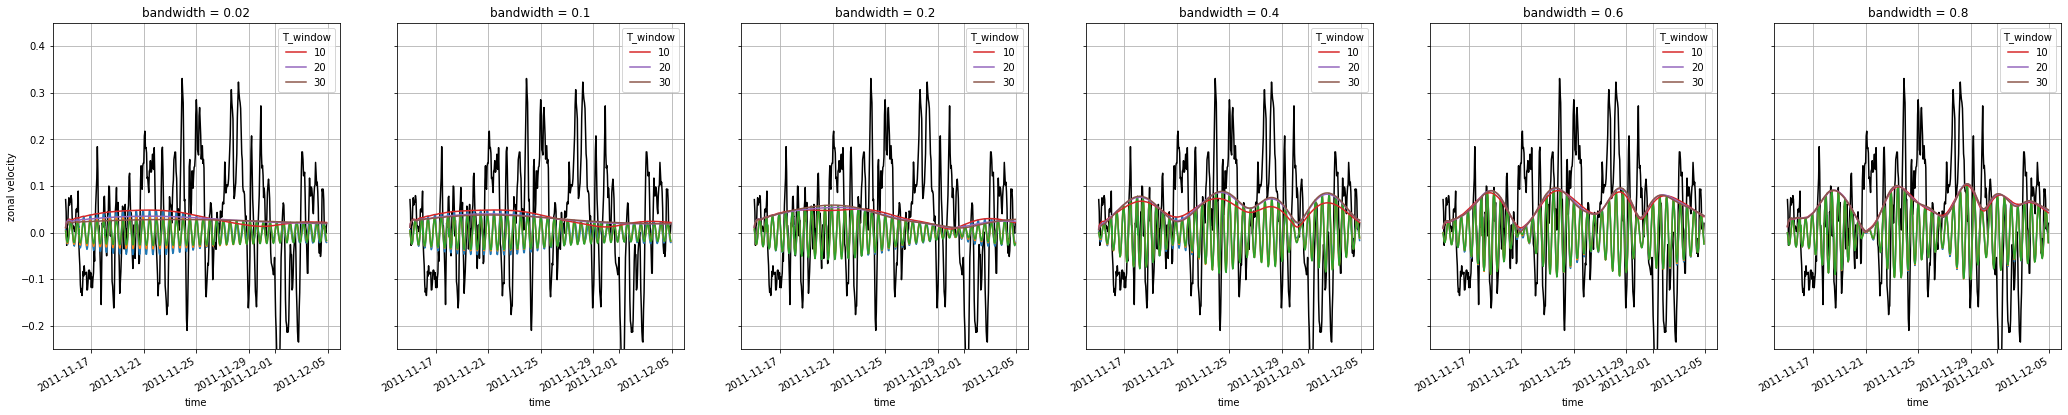

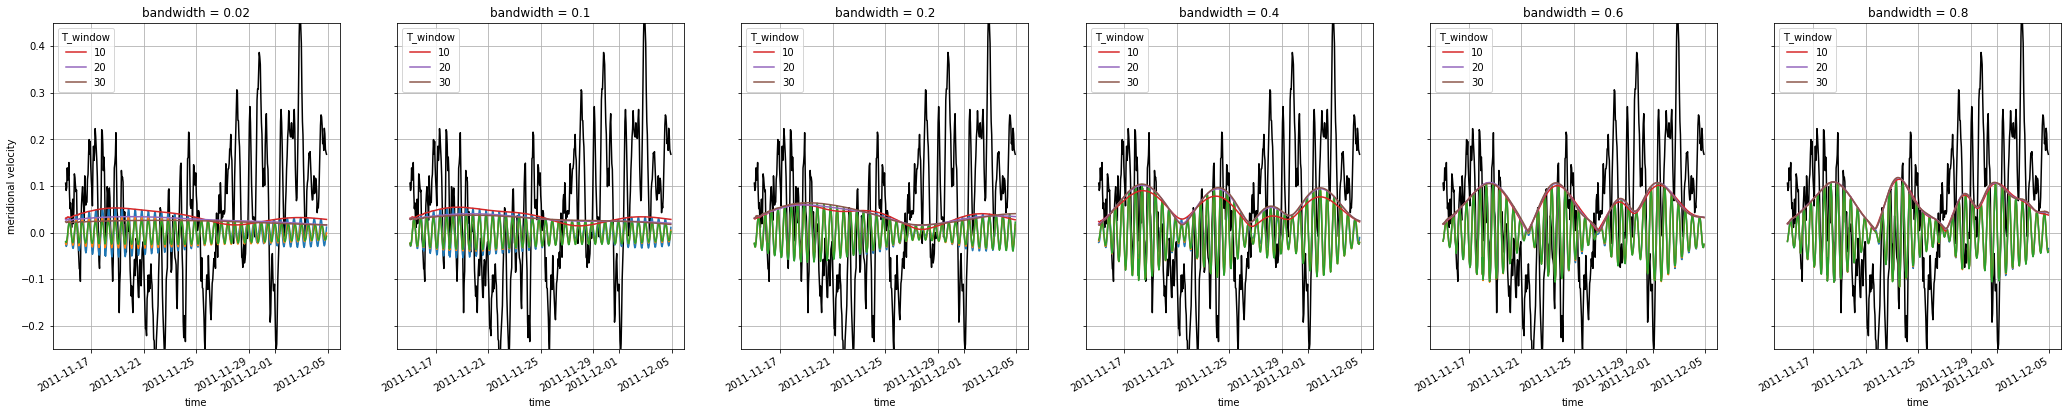

In [50]:
for v in ['zonal_velocity','meridional_velocity']:
    fig,axs = plt.subplots(1,len(bandwidths),figsize=(6*len(bandwidths),6),sharey=True)
    for dband,ax in zip(dsi.bandwidth,axs):
        dsi[v].isel(time=slice(0,20*24)).sel(bandwidth=dband,T_window=10).plot(ax=ax,c='k')
        np.real(dsi[v+'_hat']).isel(time=slice(0,20*24)).sel(bandwidth=dband).plot(ax=ax,x='time',hue='T_window')
        np.abs(dsi[v+'_hat']).isel(time=slice(0,20*24)).sel(bandwidth=dband).plot(ax=ax,x='time',hue='T_window')
        ax.grid();ax.set_ylim(-0.25,0.45);ax.set_ylabel('')
    axs[0].set_ylabel('%s %s'%(v.split('_')[0],v.split('_')[1]))

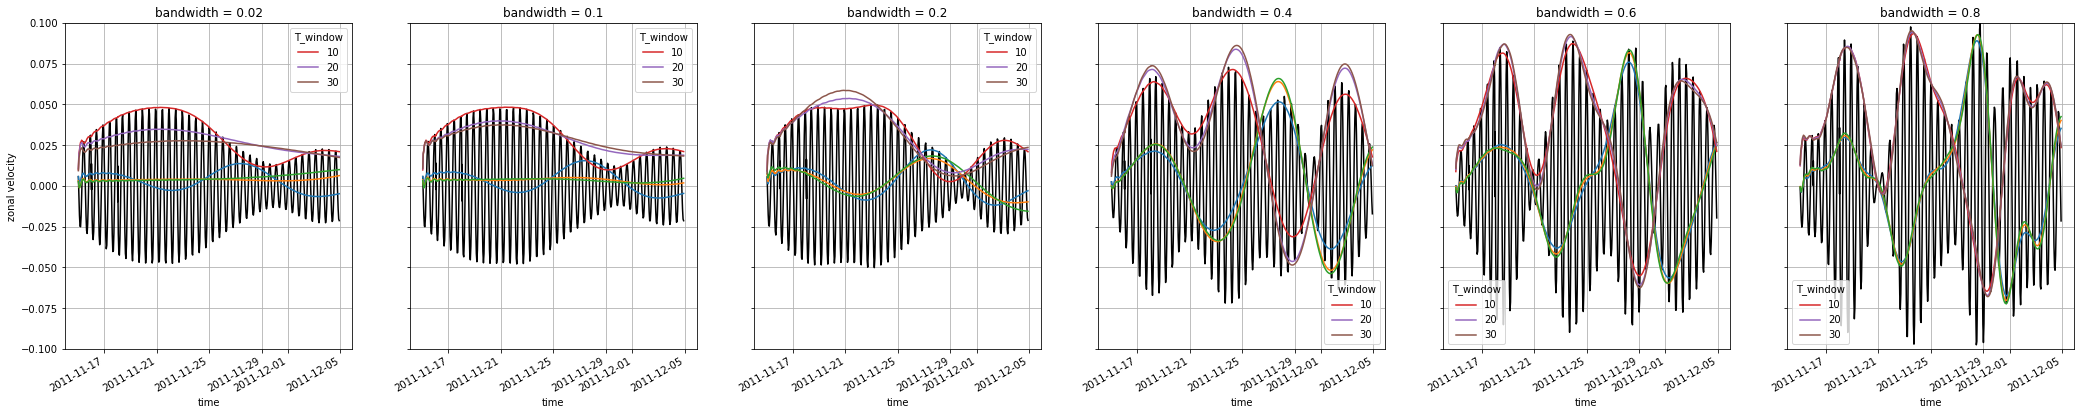

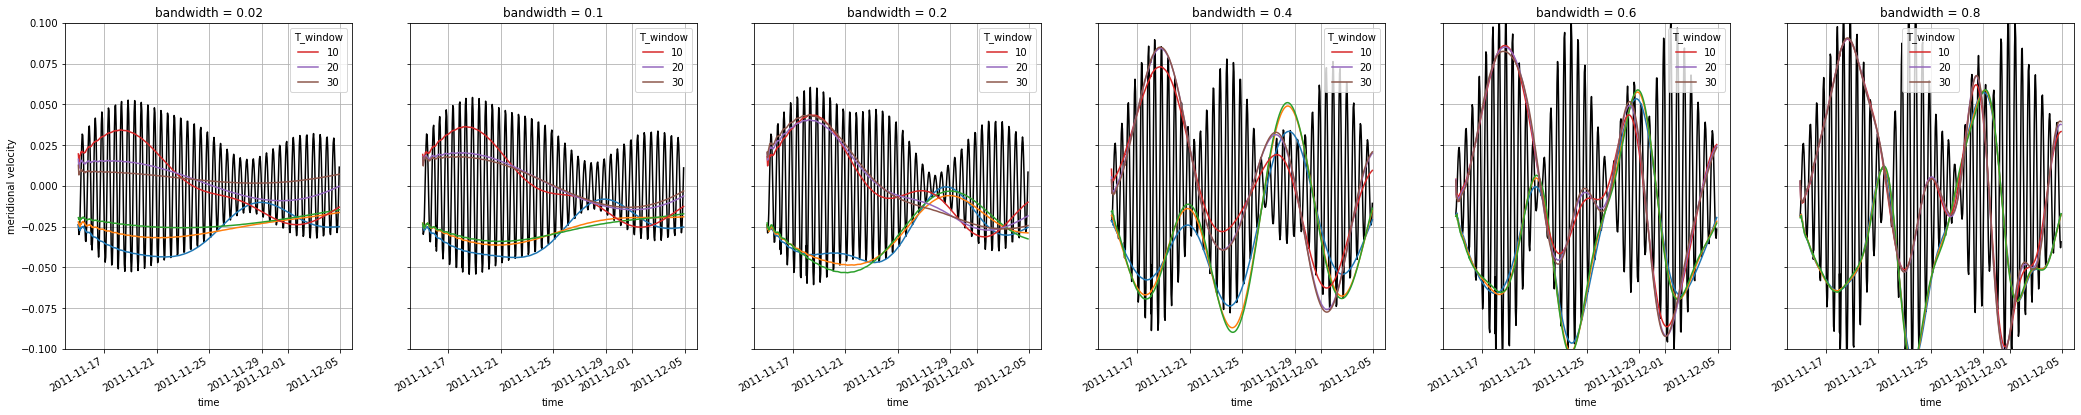

In [51]:
for v in ['zonal_velocity','meridional_velocity']:
    fig,axs = plt.subplots(1,len(bandwidths),figsize=(6*len(bandwidths),6),sharey=True)
    for dband,ax in zip(dsi.bandwidth,axs):
        np.real(dsi[v+'_hat']).isel(time=slice(0,20*24)).sel(bandwidth=dband,T_window=10).plot(ax=ax,c='k')
        np.real(dsi[v+'_demodulated']).isel(time=slice(0,20*24)).sel(bandwidth=dband).plot(ax=ax,x='time',hue='T_window')
        np.imag(dsi[v+'_demodulated']).isel(time=slice(0,20*24)).sel(bandwidth=dband).plot(ax=ax,x='time',hue='T_window')
        ax.grid();ax.set_ylim(-0.1,0.1);ax.set_ylabel('')
    axs[0].set_ylabel('%s %s'%(v.split('_')[0],v.split('_')[1]))

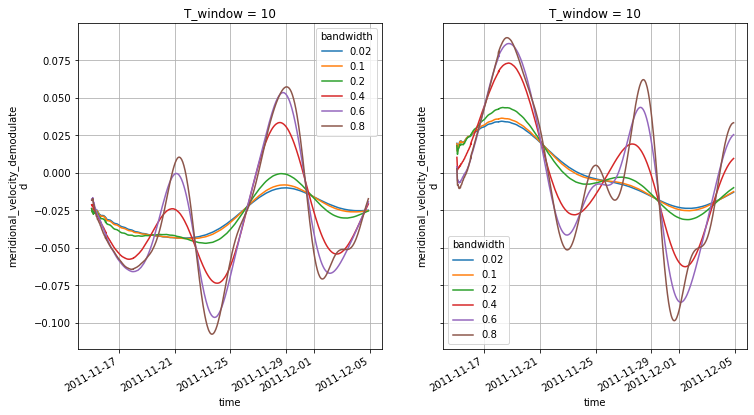

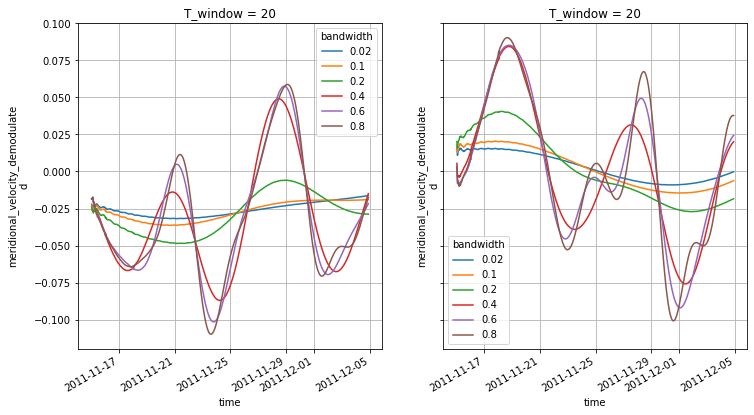

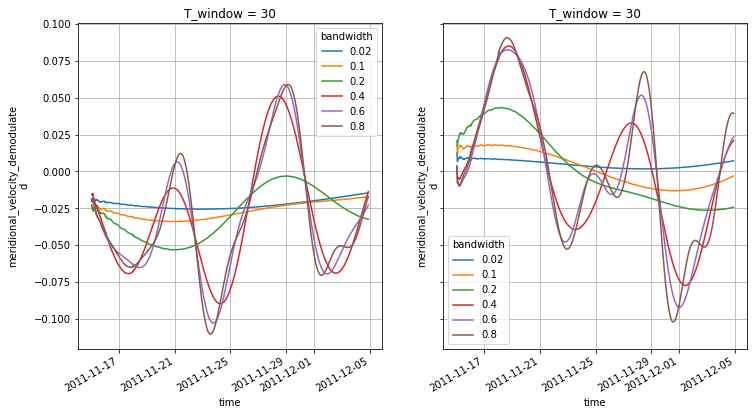

In [52]:

for T in T_window:
    fig,axs = plt.subplots(1,2,figsize=(12,6),sharey=True)
    np.real(dsi[v+'_demodulated']).isel(time=slice(0,20*24)).sel(T_window=T).plot(ax=axs[0],x='time',hue='bandwidth')
    np.imag(dsi[v+'_demodulated']).isel(time=slice(0,20*24)).sel(T_window=T).plot(ax=axs[1],x='time',hue='bandwidth');
    axs[0].grid();axs[1].grid();

In [53]:
lon_bins = np.arange(_ds.lon.min().values,_ds.lon.max().values,1)
lat_bins = np.arange(_ds.lat.min().values,_ds.lat.max().values,1)

In [61]:
tst_mean = _ds['zonal_velocity_demodulated'].groupby_bins('lon',bins=lon_bins).mean()

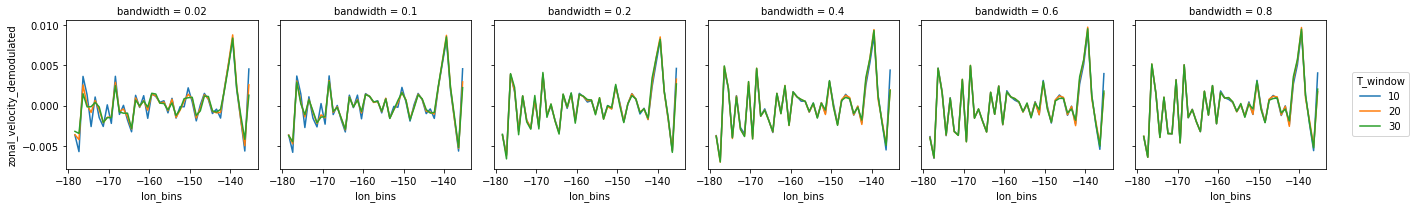

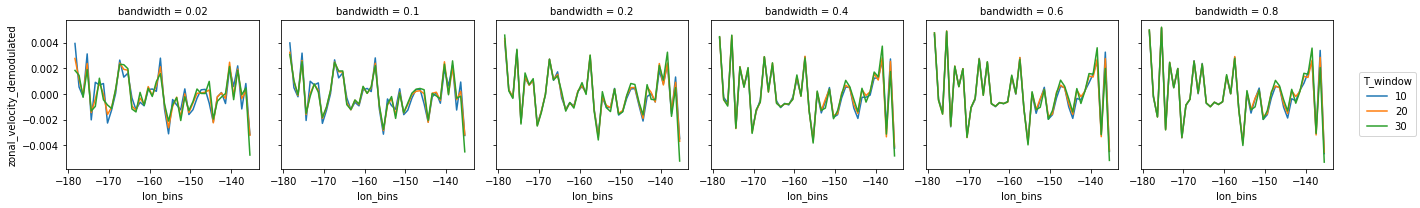

In [63]:
tst_mean.real.plot(hue='T_window',col='bandwidth')
tst_mean.imag.plot(hue='T_window',col='bandwidth')

### Autocorrelations

In [18]:


def time_window_processing(df, myfun, columns, T, N, overlap=0.5, **myfun_kwargs):
    ''' break each drifter time series into time windows and process each windows
    
    Parameters
    ----------
        
        df: Dataframe
            This dataframe represents a drifter time series
        
        T: float
            Length of the time windows
            
        myfun
            Method that will be applied to each window
            
        columns: list of str
            List of columns of df that will become inputs of myfun
            
        N: int
            Length of myfun outputs
            
        L: int
            Maximum x (used in mean_position)
            
        overlap: float
            Amount of overlap between windows. 
            Should be between 0 and 1. 
            Default is 0.5
            
        **myfun_kwargs
            Keyword arguments for myfun
    
    '''
    if hasattr(df, 'trajectory'):
        dr_id = df.trajectory.unique()[0]
    elif df.index.name=='trajectory':
        dr_id = df.index.unique()[0]
    elif hasattr(df, 'name'):
        # when mapped after groupby
        dr_id = df.name
    else:
        assert False, 'Cannot find float id'
    #
    _df = df.sort_values('time')#.set_index('time')
    #p = p.where(p.time.diff()!=0).dropna()
    #p = p.set_index('time')
    #_df = df.reset_index().sort_values('time')
    #_df = _df.drop_duplicates('time')
   # print(_df)
    time_float = [float(i)/(3600*1e9*24) for i in _df.time.values[:]-_df.time.values[0]]
    _df['time_float'] = time_float#pd.Series(time_float,index=dfi.index.compute().values)
    _df = _df.set_index('time_float')
    tmin, tmax = _df.index[0], _df.index[-1]
    #print(tmax,tmin+T)
    # need to create an empty dataframe, in case the loop below is empty
    myfun_out = myfun(*[None for c in columns], N, **myfun_kwargs) # get index from fake output
    index = ['lon','lat']+['id']+list(myfun_out.index)
    out = [pd.DataFrame({_:[] for _ in index})]
    t=tmin
    while t+T<tmax:
        #
        _p = _df.loc[t:t+T]
        # compute average position
        x, y = _p.lon.mean(),_p.lat.mean()#mean_position(_p, L)
        # apply myfun
        myfun_out = myfun(*[_p[c] for c in columns], N, **myfun_kwargs)
        # combine with mean position and time
        _out = pd.DataFrame([[x, y]+[dr_id]+list(myfun_out)],
                            columns = index,
                            index = [t+T/2.])
        out.append(_out)
        t+=T*(1-overlap)
    return pd.concat(out)

def correlate(v1, v2, N, detrend = False, dt=None):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time 
    and along the same time line.
    
    Parameters
    ----------
    
        v1, v2: ndarray, pd.Series
            Time series to correlate, the index must be time if dt is not Provided
            
        N: int
            Length of the output
            
        dt: float, optional
            Time step
            
        detrend: boolean, optional
            Turns detrending on or off. Default is False.

    See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html
    '''
    if dt is None:
        dt = v1.reset_index()['index'].diff().mean()
    
    if v1 is None and v2 is None:
        _v1 = np.random.randn(N)
        _v2 = np.random.randn(N)
        vv = np.correlate(_v1[N//2:], _v2, mode='valid')
    else:
        if detrend:
            _v1 = v1
            _v2 = v2
            v1 = signal.detrend(v1)
            v2 = signal.detrend(v2)
        #print('!!! Not implemented yet')
        # https://www.machinelearningplus.com/time-series/time-series-analysis-python/
        
        vv = np.correlate(v1.iloc[N//2:], v2, mode='valid')/(N/2)
    out = vv[:][:N]
    index=list(np.arange(N//2+1)*dt)
    return pd.Series(out,index=index)

In [19]:
def wrap_correlate(df,columns,T,N,dt,binsize):
    df_chunked = df.groupby(df.index).apply(time_window_processing,correlate,columns,T,N,dt=dt).persist()
    df_chunked = df_chunked.reset_index().rename(columns={'level_1': 'time'})
    lon_bins,lat_bins = np.arange(lonmin,lonmax,binsize),np.arange(latmin,latmax,binsize)
    x_idx,y_idx = pd.IntervalIndex.from_breaks(lon_bins),pd.IntervalIndex.from_breaks(lat_bins)
    df_chunked['lon_cut'] = df_chunked['lon'].map_partitions(pd.cut, bins=lon_bins)
    df_chunked['lat_cut'] = df_chunked['lat'].map_partitions(pd.cut, bins=lat_bins)
    return df_chunked

In [24]:
df_filtered = df_filtered.drop(columns='trajectory').reset_index().sort_values('time').set_index('trajectory')

In [27]:
V = ['zonal_velocity','meridional_velocity']
for v in V:
    df_filtered[v+'_demodulated_real'] = df_filtered[v+'_demodulated'].apply(lambda x: np.real(x))
    df_filtered[v+'_demodulated_imag'] = df_filtered[v+'_demodulated'].apply(lambda x: np.imag(x))

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3522: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('zonal_velocity_demodulated', 'float64'))

  warnings.warn(meta_warning(meta))
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3522: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  B

### One drifter

In [28]:
#_df = df_selected[df_selected.trajectory==37000596].persist()
_df = df_filtered.loc[37000596].persist()

In [29]:
dt = 1/24
T=80
N=int(T/dt)

In [33]:
v1,v2 = 'zonal_velocity_demodulated_real','zonal_velocity_demodulated_real'
test = _df.groupby(_df.index).apply(time_window_processing,correlate,[v1,v2],T,N,dt=dt).compute()

<ipython-input-33-0771f4ae9301>:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  test = _df.groupby(_df.index).apply(time_window_processing,correlate,[v1,v2],T,N,dt=dt).compute()


In [34]:
test = test.reset_index(level=[1]).rename(columns={'level_1': 'time'})

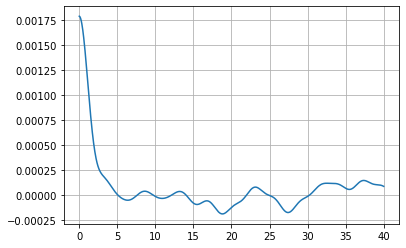

In [36]:
test.drop(columns=['time','id','lon','lat']).mean().plot();
plt.grid();

In [42]:
v1,v2 = 'zonal_velocity_demodulated_real','zonal_velocity_demodulated_real'
df_autocorr_rr = wrap_correlate(df_filtered,[v1,v2],T,N,dt,binsize=0.5)
df_autocorr_rr
#test2 = df_selected.groupby(df_selected.index).apply(time_window_processing,correlate,['zonal_velocity','zonal_velocity'],80,int(80/dt),dt=dt).persist()

<ipython-input-41-90dbed929125>:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_chunked = df.groupby(df.index).apply(time_window_processing,correlate,columns,T,N,dt=dt).persist()


Dask DataFrame Structure:
               trajectory   time      lon      lat       id      0.0 0.041666666666666664 0.08333333333333333    0.125 0.16666666666666666 0.20833333333333331     0.25 0.29166666666666663 0.3333333333333333    0.375 0.41666666666666663 0.4583333333333333      0.5 0.5416666666666666 0.5833333333333333    0.625 0.6666666666666666 0.7083333333333333     0.75 0.7916666666666666 0.8333333333333333    0.875 0.9166666666666666 0.9583333333333333      1.0 1.0416666666666665 1.0833333333333333    1.125 1.1666666666666665 1.2083333333333333     1.25 1.2916666666666665 1.3333333333333333    1.375 1.4166666666666665 1.4583333333333333      1.5 1.5416666666666665 1.5833333333333333    1.625 1.6666666666666665 1.7083333333333333     1.75 1.7916666666666665 1.8333333333333333    1.875 1.9166666666666665 1.9583333333333333      2.0 2.0416666666666665 2.083333333333333    2.125 2.1666666666666665 2.208333333333333     2.25 2.2916666666666665 2.333333333333333    2.375 2.4166666666666665 2.458333333333333      2.5 2.5416666666666665 2.583333333333333    2.625 2.6666666666666665 2.708333333333333     2.75 2.7916666666666665 2.833333333333333    2.875 2.9166666666666665 2.958333333333333      3.0 3.0416666666666665 3.083333333333333    3.125 3.1666666666666665 3.208333333333333     3.25 3.2916666666666665 3.333333333333333    3.375 3.4166666666666665 3.458333333333333      3.5 3.5416666666666665 3.583333333333333    3.625 3.6666666666666665 3.708333333333333     3.75 3.7916666666666665 3.833333333333333    3.875 3.9166666666666665 3.958333333333333      4.0 4.041666666666666 4.083333333333333    4.125 4.166666666666666 4.208333333333333     4.25 4.291666666666666 4.333333333333333    4.375 4.416666666666666 4.458333333333333      4.5 4.541666666666666 4.583333333333333    4.625 4.666666666666666 4.708333333333333     4.75 4.791666666666666 4.833333333333333    4.875 4.916666666666666 4.958333333333333      5.0 5.041666666666666 5.083333333333333    5.125 5.166666666666666 5.208333333333333     5.25 5.291666666666666 5.333333333333333    5.375 5.416666666666666 5.458333333333333      5.5 5.541666666666666 5.583333333333333    5.625 5.666666666666666 5.708333333333333     5.75 5.791666666666666 5.833333333333333    5.875 5.916666666666666 5.958333333333333      6.0 6.041666666666666 6.083333333333333    6.125 6.166666666666666 6.208333333333333     6.25 6.291666666666666 6.333333333333333    6.375 6.416666666666666 6.458333333333333      6.5 6.541666666666666 6.583333333333333    6.625 6.666666666666666 6.708333333333333     6.75 6.791666666666666 6.833333333333333    6.875 6.916666666666666 6.958333333333333      7.0 7.041666666666666 7.083333333333333    7.125 7.166666666666666 7.208333333333333     7.25 7.291666666666666 7.333333333333333    7.375 7.416666666666666 7.458333333333333      7.5 7.541666666666666 7.583333333333333    7.625 7.666666666666666 7.708333333333333     7.75 7.791666666666666 7.833333333333333    7.875 7.916666666666666 7.958333333333333      8.0 8.041666666666666 8.083333333333332    8.125 8.166666666666666 8.208333333333332     8.25 8.291666666666666 8.333333333333332    8.375 8.416666666666666 8.458333333333332      8.5 8.541666666666666 8.583333333333332    8.625 8.666666666666666 8.708333333333332     8.75 8.791666666666666 8.833333333333332    8.875 8.916666666666666 8.958333333333332      9.0 9.041666666666666 9.083333333333332    9.125 9.166666666666666 9.208333333333332     9.25 9.291666666666666 9.333333333333332    9.375 9.416666666666666 9.458333333333332      9.5 9.541666666666666 9.583333333333332    9.625 9.666666666666666 9.708333333333332     9.75 9.791666666666666 9.833333333333332    9.875 9.916666666666666 9.958333333333332     10.0 10.041666666666666 10.083333333333332   10.125 10.166666666666666 10.208333333333332    10.25 10.291666666666666 10.333333333333332   10.375 10.416666666666666 10.458333333333332     10.5 10.541666666666666 10.583333333333332   10.625 10.666666666666

In [66]:
rr = df_autocorr_rr.groupby(['lon_cut','lat_cut']).mean().compute()
#Converting pandas dataframe in xarray dataset:
##rr.set_index(rr.index.map(lambda v: v.mid))
ds = (pd.melt(rr
              .drop(columns=['id','time','lon','lat','trajectory'])
              .reset_index(), id_vars=['lon_cut','lat_cut'], var_name='lag')
              .rename(columns={'lon_cut': 'lon_bins','lat_cut': 'lat_bins', 'value': 'rr'})).to_xarray().set_index(index=['lon_bins','lat_bins','lag']).unstack()

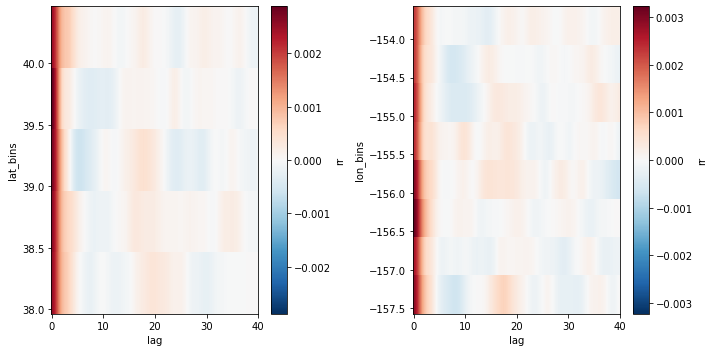

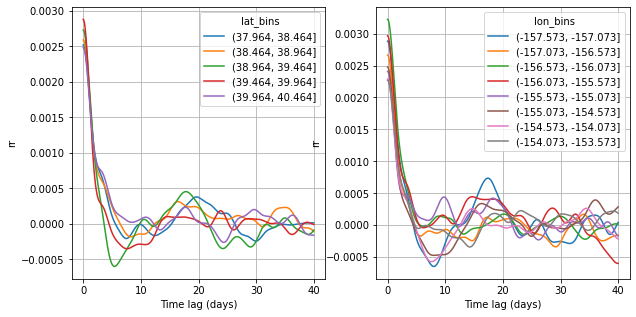

In [64]:
v1,v2 = 'zonal_velocity_demodulated_real','zonal_velocity_demodulated_imag'
df_autocorr_ri = wrap_correlate(df_filtered,[v1,v2],T,N,dt,binsize=0.5)
df_autocorr_ri

<ipython-input-41-90dbed929125>:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_chunked = df.groupby(df.index).apply(time_window_processing,correlate,columns,T,N,dt=dt).persist()


Dask DataFrame Structure:
               trajectory   time      lon      lat       id      0.0 0.041666666666666664 0.08333333333333333    0.125 0.16666666666666666 0.20833333333333331     0.25 0.29166666666666663 0.3333333333333333    0.375 0.41666666666666663 0.4583333333333333      0.5 0.5416666666666666 0.5833333333333333    0.625 0.6666666666666666 0.7083333333333333     0.75 0.7916666666666666 0.8333333333333333    0.875 0.9166666666666666 0.9583333333333333      1.0 1.0416666666666665 1.0833333333333333    1.125 1.1666666666666665 1.2083333333333333     1.25 1.2916666666666665 1.3333333333333333    1.375 1.4166666666666665 1.4583333333333333      1.5 1.5416666666666665 1.5833333333333333    1.625 1.6666666666666665 1.7083333333333333     1.75 1.7916666666666665 1.8333333333333333    1.875 1.9166666666666665 1.9583333333333333      2.0 2.0416666666666665 2.083333333333333    2.125 2.1666666666666665 2.208333333333333     2.25 2.2916666666666665 2.333333333333333    2.375 2.4166666666666665 2.458333333333333      2.5 2.5416666666666665 2.583333333333333    2.625 2.6666666666666665 2.708333333333333     2.75 2.7916666666666665 2.833333333333333    2.875 2.9166666666666665 2.958333333333333      3.0 3.0416666666666665 3.083333333333333    3.125 3.1666666666666665 3.208333333333333     3.25 3.2916666666666665 3.333333333333333    3.375 3.4166666666666665 3.458333333333333      3.5 3.5416666666666665 3.583333333333333    3.625 3.6666666666666665 3.708333333333333     3.75 3.7916666666666665 3.833333333333333    3.875 3.9166666666666665 3.958333333333333      4.0 4.041666666666666 4.083333333333333    4.125 4.166666666666666 4.208333333333333     4.25 4.291666666666666 4.333333333333333    4.375 4.416666666666666 4.458333333333333      4.5 4.541666666666666 4.583333333333333    4.625 4.666666666666666 4.708333333333333     4.75 4.791666666666666 4.833333333333333    4.875 4.916666666666666 4.958333333333333      5.0 5.041666666666666 5.083333333333333    5.125 5.166666666666666 5.208333333333333     5.25 5.291666666666666 5.333333333333333    5.375 5.416666666666666 5.458333333333333      5.5 5.541666666666666 5.583333333333333    5.625 5.666666666666666 5.708333333333333     5.75 5.791666666666666 5.833333333333333    5.875 5.916666666666666 5.958333333333333      6.0 6.041666666666666 6.083333333333333    6.125 6.166666666666666 6.208333333333333     6.25 6.291666666666666 6.333333333333333    6.375 6.416666666666666 6.458333333333333      6.5 6.541666666666666 6.583333333333333    6.625 6.666666666666666 6.708333333333333     6.75 6.791666666666666 6.833333333333333    6.875 6.916666666666666 6.958333333333333      7.0 7.041666666666666 7.083333333333333    7.125 7.166666666666666 7.208333333333333     7.25 7.291666666666666 7.333333333333333    7.375 7.416666666666666 7.458333333333333      7.5 7.541666666666666 7.583333333333333    7.625 7.666666666666666 7.708333333333333     7.75 7.791666666666666 7.833333333333333    7.875 7.916666666666666 7.958333333333333      8.0 8.041666666666666 8.083333333333332    8.125 8.166666666666666 8.208333333333332     8.25 8.291666666666666 8.333333333333332    8.375 8.416666666666666 8.458333333333332      8.5 8.541666666666666 8.583333333333332    8.625 8.666666666666666 8.708333333333332     8.75 8.791666666666666 8.833333333333332    8.875 8.916666666666666 8.958333333333332      9.0 9.041666666666666 9.083333333333332    9.125 9.166666666666666 9.208333333333332     9.25 9.291666666666666 9.333333333333332    9.375 9.416666666666666 9.458333333333332      9.5 9.541666666666666 9.583333333333332    9.625 9.666666666666666 9.708333333333332     9.75 9.791666666666666 9.833333333333332    9.875 9.916666666666666 9.958333333333332     10.0 10.041666666666666 10.083333333333332   10.125 10.166666666666666 10.208333333333332    10.25 10.291666666666666 10.333333333333332   10.375 10.416666666666666 10.458333333333332     10.5 10.541666666666666 10.583333333333332   10.625 10.666666666666

In [68]:
ri = df_autocorr_ri.groupby(['lon_cut','lat_cut']).mean().compute()
#Converting pandas dataframe in xarray dataset:
##rr.set_index(rr.index.map(lambda v: v.mid))
ds_ri = (pd.melt(ri
              .drop(columns=['id','time','lon','lat','trajectory'])
              .reset_index(), id_vars=['lon_cut','lat_cut'], var_name='lag')
              .rename(columns={'lon_cut': 'lon_bins','lat_cut': 'lat_bins', 'value': 'ri'})).to_xarray().set_index(index=['lon_bins','lat_bins','lag']).unstack()

In [70]:
ds['ri'] = ds_ri.ri

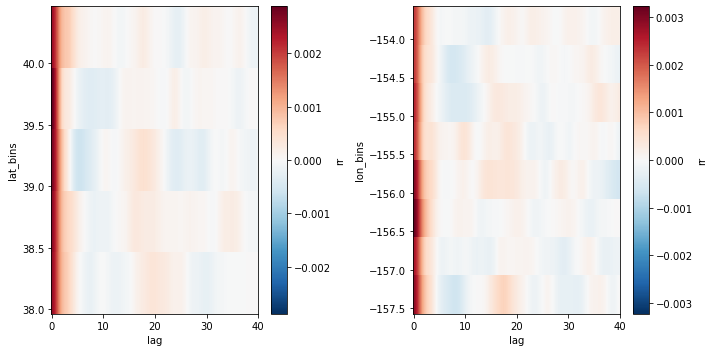

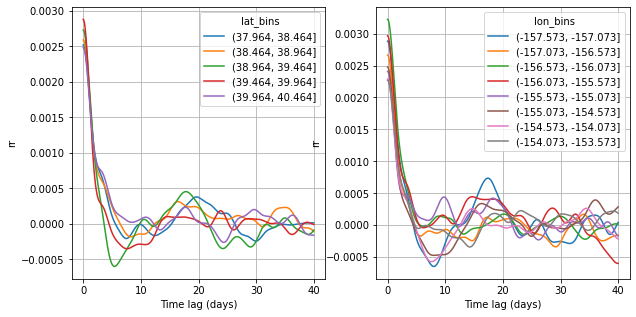

In [71]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
ds.rr.mean('lon_bins').plot(ax=axs[0])
ds.rr.mean('lat_bins').plot(ax=axs[1]);
fig.tight_layout();
fig,axs = plt.subplots(1,2,figsize=(10,5))
ds.rr.mean('lon_bins').plot(ax=axs[0],hue='lat_bins')
ds.rr.mean('lat_bins').plot(ax=axs[1],hue='lon_bins')
for ax in axs:
    ax.grid();ax.set_xlabel('Time lag (days)')
#ds.rr.plot(hue='lon_bins')

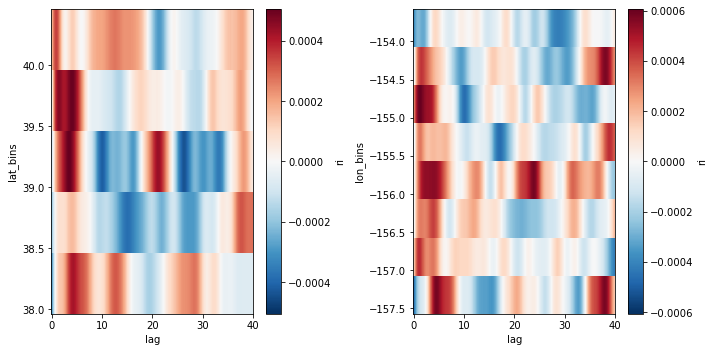

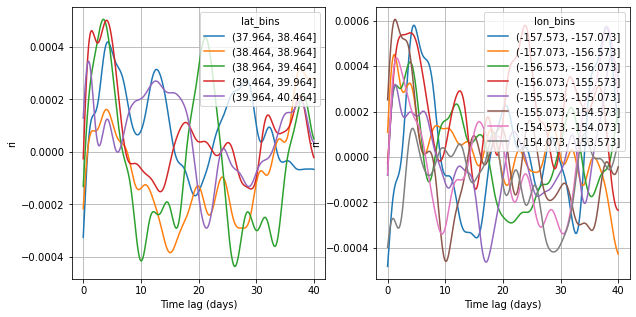

In [72]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
ds.ri.mean('lon_bins').plot(ax=axs[0])
ds.ri.mean('lat_bins').plot(ax=axs[1]);
fig.tight_layout();
fig,axs = plt.subplots(1,2,figsize=(10,5))
ds.ri.mean('lon_bins').plot(ax=axs[0],hue='lat_bins')
ds.ri.mean('lat_bins').plot(ax=axs[1],hue='lon_bins')
for ax in axs:
    ax.grid();ax.set_xlabel('Time lag (days)')
#ds.rr.plot(hue='lon_bins')

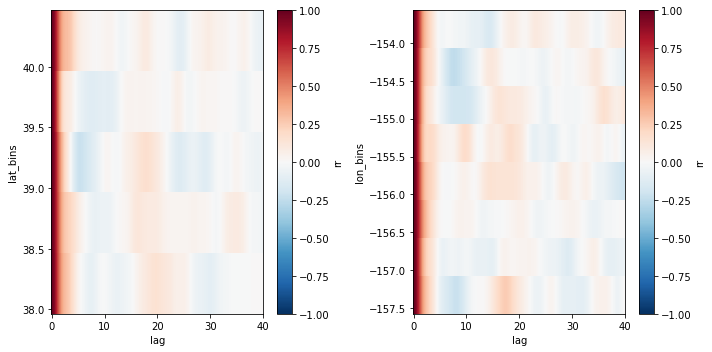

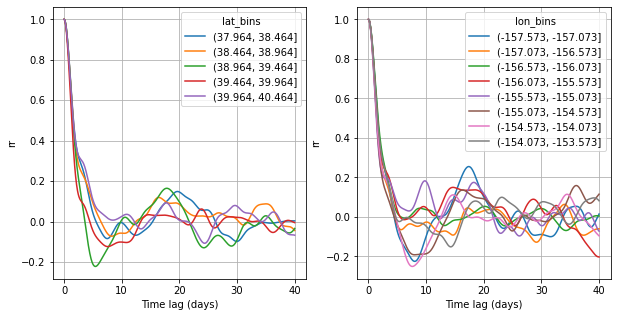

In [74]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
(ds.rr.mean('lon_bins')/ds.rr.mean('lon_bins').isel(lag=0)).plot(ax=axs[0])
(ds.rr.mean('lat_bins')/ds.rr.mean('lat_bins').isel(lag=0)).plot(ax=axs[1]);
fig.tight_layout();
fig,axs = plt.subplots(1,2,figsize=(10,5))
(ds.rr.mean('lon_bins')/ds.rr.mean('lon_bins').isel(lag=0)).plot(ax=axs[0],hue='lat_bins')
(ds.rr.mean('lat_bins')/ds.rr.mean('lat_bins').isel(lag=0)).plot(ax=axs[1],hue='lon_bins')
for ax in axs:
    ax.grid();ax.set_xlabel('Time lag (days)')
#ds.rr.plot(hue='lon_bins')

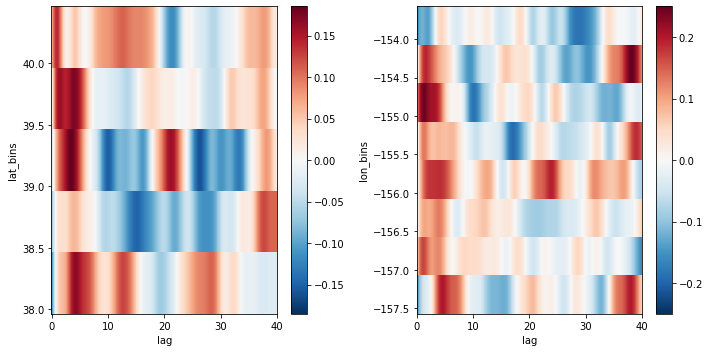

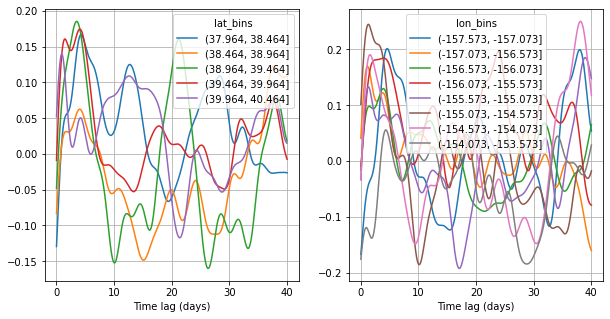

In [75]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
(ds.ri.mean('lon_bins')/ds.rr.mean('lon_bins').isel(lag=0)).plot(ax=axs[0])
(ds.ri.mean('lat_bins')/ds.rr.mean('lat_bins').isel(lag=0)).plot(ax=axs[1]);
fig.tight_layout();
fig,axs = plt.subplots(1,2,figsize=(10,5))
(ds.ri.mean('lon_bins')/ds.rr.mean('lon_bins').isel(lag=0)).plot(ax=axs[0],hue='lat_bins')
(ds.ri.mean('lat_bins')/ds.rr.mean('lat_bins').isel(lag=0)).plot(ax=axs[1],hue='lon_bins')
for ax in axs:
    ax.grid();ax.set_xlabel('Time lag (days)')
#ds.rr.plot(hue='lon_bins')

In [39]:
tt = t['T10band0.4'].reset_index().sort_values('time').set_index('trajectory').persist()

In [78]:
def demeaned(df,v):
    df[v+'_demean'] = df.groupby('time').transform(lambda x: x-x.mean())[v]
    return df
#_tt = tt.groupby('time').transform(lambda x: x-x.mean())['zonal_velocity'].persist()

In [80]:
tt.map_partitions(demeaned,'zonal_velocity').persist()

Dask DataFrame Structure:
                         time      lat      lon        z zonal_velocity meridional_velocity sea_level temperature salinity zonal_velocity_hat meridional_velocity_hat zonal_velocity_demodulated meridional_velocity_demodulated zonal_velocity_demean
npartitions=1                                                                                                                                                                                                                                         
37000023       datetime64[ns]  float64  float64  float64        float64             float32   float32     float32  float32         complex128              complex128                 complex128                      complex128               float64
38001668                  ...      ...      ...      ...            ...                 ...       ...         ...      ...                ...                     ...                        ...                             ...                   ...
Dask Name: demeaned, 1 tasks

In [61]:
def combine_autocov(dict_df, Tw,dband,T,N,dt,demean=True):
#v1,v2 = 'zonal_velocity_demodulated_real','zonal_velocity_demodulated_real'
    df_filtered = dict_df['T'+str(Tw)+'band'+str(dband)]
    df_filtered = df_filtered.reset_index().sort_values('time').set_index('trajectory').persist()
    df_filtered = df_filtered.map_partitions(demeaned,'zonal_velocity').persist()
    V = ['zonal_velocity','meridional_velocity']
    for v in V:
        df_filtered[v+'_demodulated_real'] = df_filtered[v+'_demodulated'].apply(lambda x: np.real(x),meta=(v+'_demodulated_real','float64'))
        df_filtered[v+'_demodulated_imag'] = df_filtered[v+'_demodulated'].apply(lambda x: np.imag(x),meta=(v+'_demodulated_imag','float64'))
    v1,v2 = 'zonal_velocity_demodulated_real','zonal_velocity_demodulated_imag'
    if demean:
        
        _v1 = df_filtered.groupby('time').transform(lambda x: x-x.mean())[v1]
        _v2 = df_filtered.groupby('time').transform(lambda x: x-x.mean())[v2]
    else:
#    df_filtered[v1] = (df_filtered[v1]-df_filtered.groupby('time')[v1].mean().set_index(df_filtered[v1].index))
    #    df_filtered[v2] = (df_filtered-df_filtered.groupby('time').mean())[v2]
    df_autocorr_rr = wrap_correlate(df_filtered,[v1,v1],T,N,dt,binsize=0.5)
    df_autocorr_ri = wrap_correlate(df_filtered,[v1,v2],T,N,dt,binsize=0.5)
#df_autocorr_rr

    rr = df_autocorr_rr.groupby(['lon_cut','lat_cut']).mean().compute()
#Converting pandas dataframe in xarray dataset:
##rr.set_index(rr.index.map(lambda v: v.mid))
    ds = (pd.melt(rr
                  .drop(columns=['id','time','lon','lat','trajectory'])
                  .reset_index(), id_vars=['lon_cut','lat_cut'], var_name='lag')
                  .rename(columns={'lon_cut': 'lon_bins','lat_cut': 'lat_bins', 'value': 'rr'})
         ).to_xarray().set_index(index=['lon_bins','lat_bins','lag']).unstack()
    ri = df_autocorr_ri.groupby(['lon_cut','lat_cut']).mean().compute()
#Converting pandas dataframe in xarray dataset:
##rr.set_index(rr.index.map(lambda v: v.mid))
    ds['ri'] = (pd.melt(ri
                  .drop(columns=['id','time','lon','lat','trajectory'])
                  .reset_index(), id_vars=['lon_cut','lat_cut'], var_name='lag')
                  .rename(columns={'lon_cut': 'lon_bins','lat_cut': 'lat_bins', 'value': 'ri'})
               ).to_xarray().set_index(index=['lon_bins','lat_bins','lag']).unstack().ri
    return ds

In [109]:
def combine_nested_wrap(T_window,bandwidths,T,dt):
    ds = xr.combine_nested([[combine_autocov(t,Tw,dband,T,int(T/dt),dt) for Tw in T_window
                           ] for dband in bandwidths],concat_dim=['T_window','bandwidth'])
    return ds
tst = xr.apply_ufunc(combine_nested_wrap,T_window,[2*d for d in bandwidths[:2]], T,dt,
                    dask='parallelized', output_dtypes=[np.float64], #np.float64
                    input_core_dims=None, #[['time'], ['time']]
                    output_core_dims=[['lags'],['lon_bins'],['lat_bins'],['T_window'],['bandwidth']])
                    #dask_gufunc_kwargs={'output_sizes':{'lags': lags.size,'lags': lags.size}}, kwargs=kwargs)

<ipython-input-41-90dbed929125>:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_chunked = df.groupby(df.index).apply(time_window_processing,correlate,columns,T,N,dt=dt).persist()
<ipython-input-41-90dbed929125>:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_chunked = df.groupby(df.index).apply(time_window_processing,correlate,columns,T,N,dt=dt).persist()
<ipython-input-41-90dbed929125>:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Be

KeyboardInterrupt: 

In [62]:
T = 80
_ds = xr.combine_nested([[combine_autocov(t,Tw,dband,T,int(T/dt),dt) for Tw in H.T_window.values[:]] for dband in H.bandwidth.values[2:]
                         ],concat_dim=['bandwidth','T_window'])

AttributeError: 'Series' object has no attribute 'set_index'

In [33]:
_ds = test.assign_coords({'T_window':H.T_window.values[:],'bandwidth':H.bandwidth.values[2:]})
_ds# = test.rename_dims({'dim1':'bandwidth','dim2':'T_window'})

<xarray.Dataset>
Dimensions:    (T_window: 3, bandwidth: 4, lag: 961, lat_bins: 5, lon_bins: 8)
Coordinates:
  * lon_bins   (lon_bins) object (-157.573, -157.073] ... (-154.073, -153.573]
  * lat_bins   (lat_bins) object (37.964, 38.464] ... (39.964, 40.464]
  * lag        (lag) float64 0.0 0.04167 0.08333 0.125 ... 39.92 39.96 40.0
  * T_window   (T_window) int64 10 20 30
  * bandwidth  (bandwidth) float64 0.2 0.4 0.6 0.8
Data variables:
    rr         (T_window, bandwidth, lon_bins, lat_bins, lag) float64 0.00074...
    ri         (T_window, bandwidth, lon_bins, lat_bins, lag) float64 0.00037...

In [42]:
_ds = test

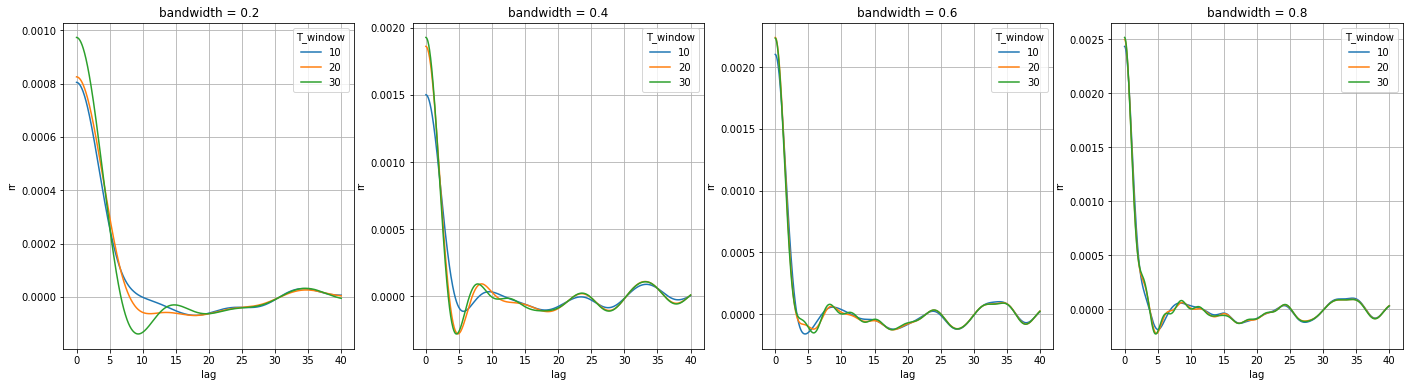

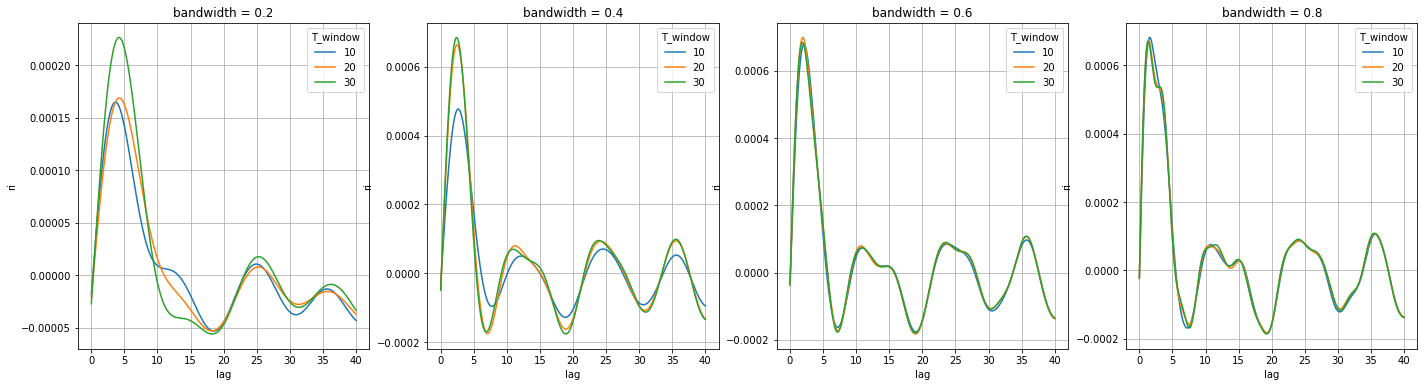

In [43]:
fig,axs = plt.subplots(1,len(_ds.bandwidth),figsize=(6*len(_ds.bandwidth),6))
for dband,ax in zip(_ds.bandwidth,axs):
    (_ds.rr.mean(['lon_bins','lat_bins'])).sel(bandwidth=dband).plot(hue='T_window',ax=ax)
    ax.grid()
fig,axs = plt.subplots(1,len(_ds.bandwidth),figsize=(6*len(_ds.bandwidth),6))
for dband,ax in zip(_ds.bandwidth,axs):
    (_ds.ri.mean(['lon_bins','lat_bins'])).sel(bandwidth=dband).plot(hue='T_window',ax=ax)
    ax.grid()

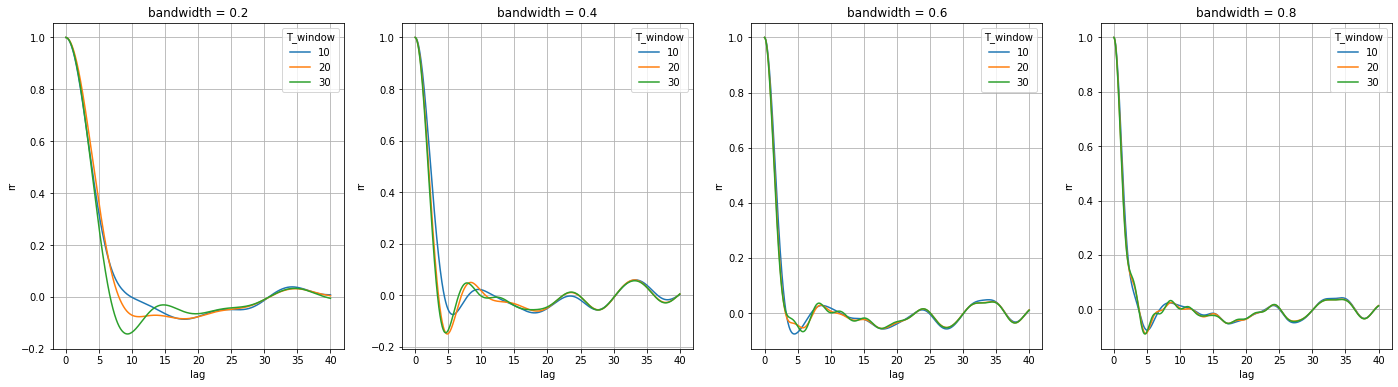

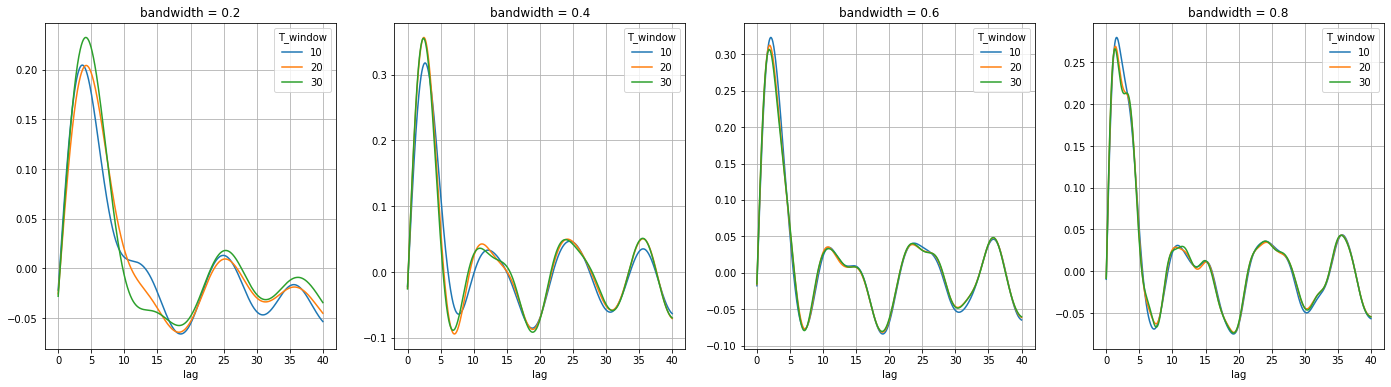

In [44]:
fig,axs = plt.subplots(1,len(_ds.bandwidth),figsize=(6*len(_ds.bandwidth),6))
for dband,ax in zip(_ds.bandwidth,axs):
    (_ds.rr.mean(['lon_bins','lat_bins'])/_ds.rr.mean(['lon_bins','lat_bins']).isel(lag=0)).sel(bandwidth=dband).plot(hue='T_window',ax=ax)
    ax.grid()
fig,axs = plt.subplots(1,len(_ds.bandwidth),figsize=(6*len(_ds.bandwidth),6))
for dband,ax in zip(_ds.bandwidth,axs):
    (_ds.ri.mean(['lon_bins','lat_bins'])/_ds.rr.mean(['lon_bins','lat_bins']).isel(lag=0)).sel(bandwidth=dband).plot(hue='T_window',ax=ax)
    ax.grid()

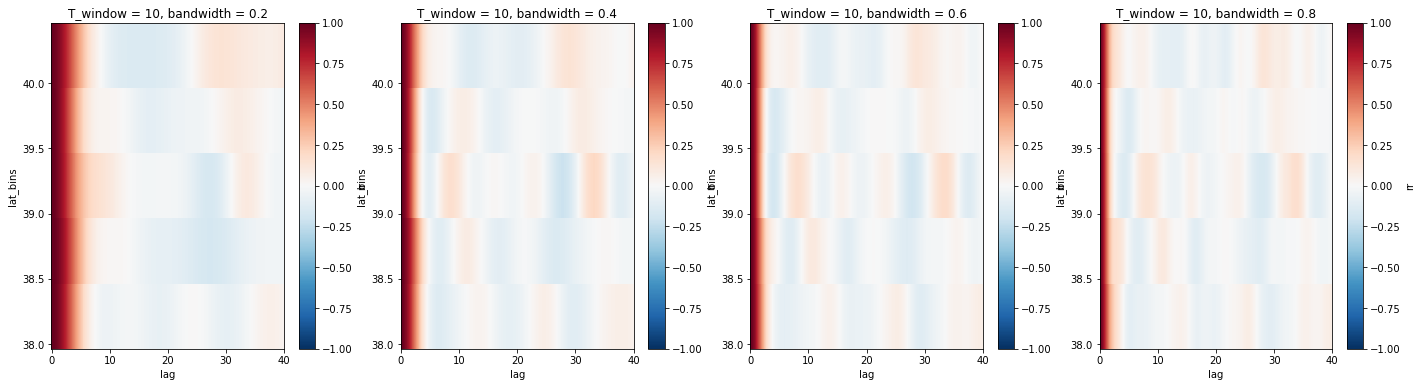

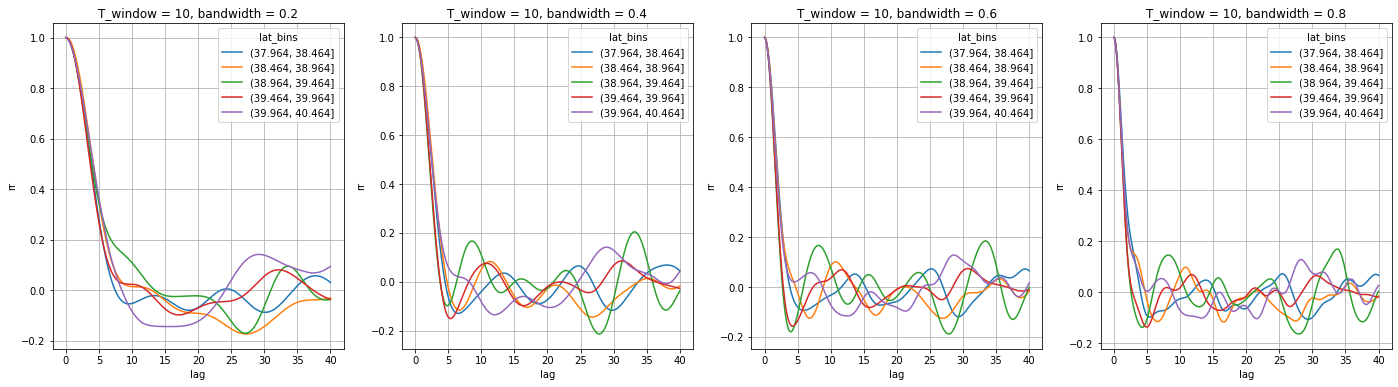

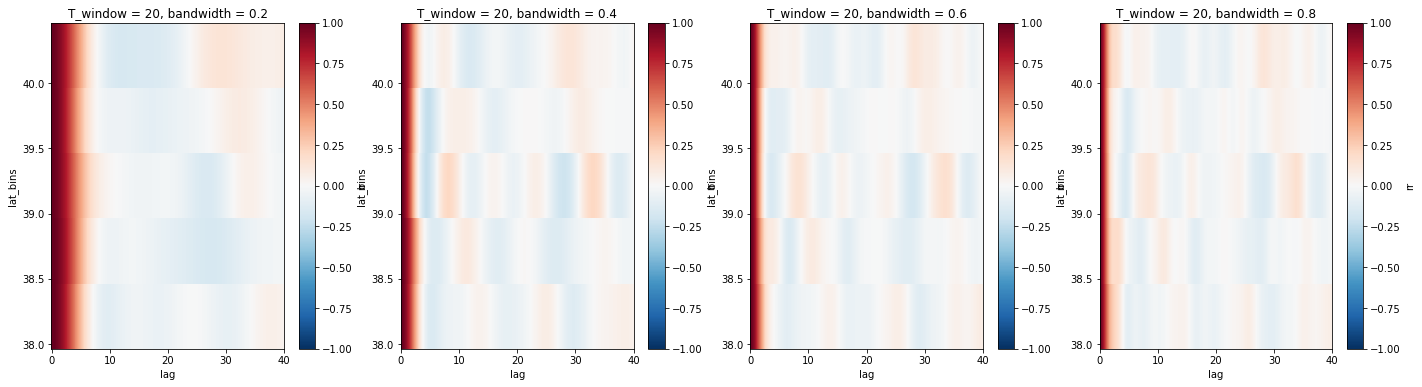

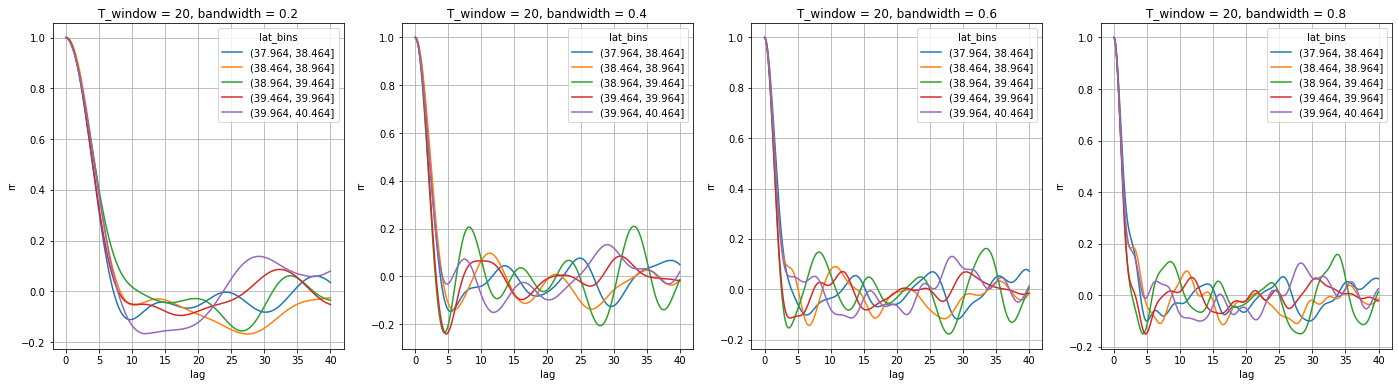

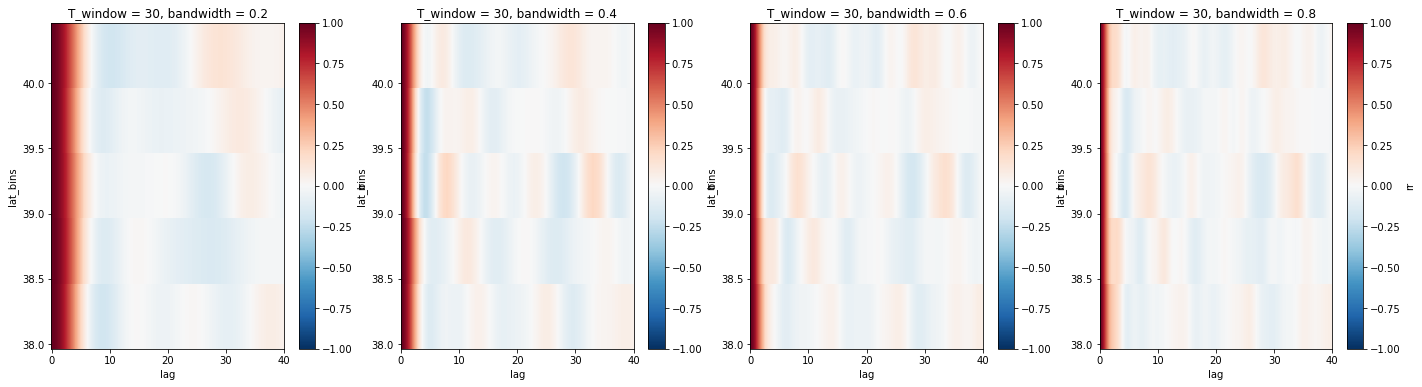

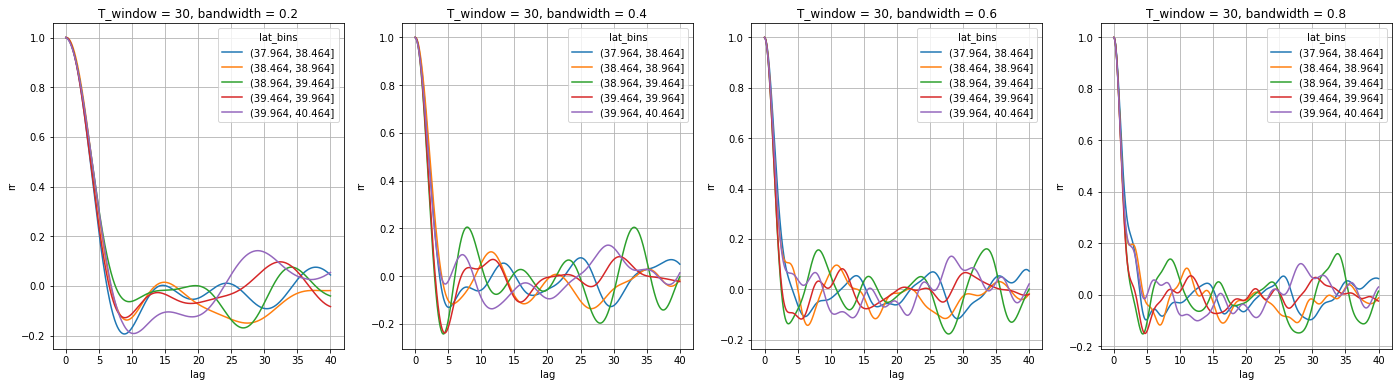

In [45]:
for Tw in _ds.T_window:
    fig,axs = plt.subplots(1,len(_ds.bandwidth),figsize=(6*len(_ds.bandwidth),6))
    for dband,ax in zip(_ds.bandwidth,axs):
        (_ds.rr.sel(T_window=Tw).mean(['lon_bins'])/_ds.rr.sel(T_window=Tw).mean(['lon_bins']).isel(lag=0)).sel(bandwidth=dband).plot(ax=ax)
    fig,axs = plt.subplots(1,len(_ds.bandwidth),figsize=(6*len(_ds.bandwidth),6))
    for dband,ax in zip(_ds.bandwidth,axs):
        (_ds.rr.sel(T_window=Tw).mean(['lon_bins'])/_ds.rr.sel(T_window=Tw).mean(['lon_bins']).isel(lag=0)).sel(bandwidth=dband).plot(ax=ax,hue='lat_bins')
        ax.grid()

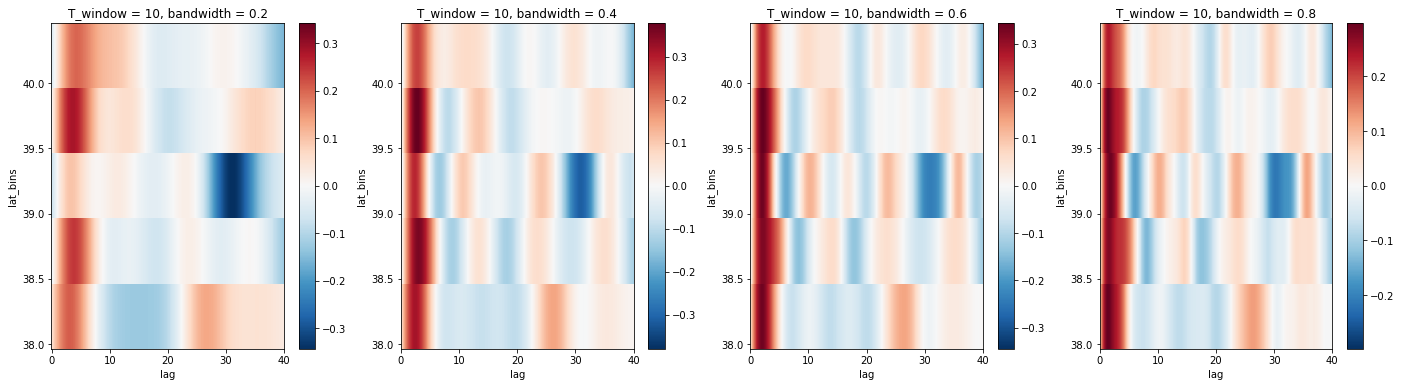

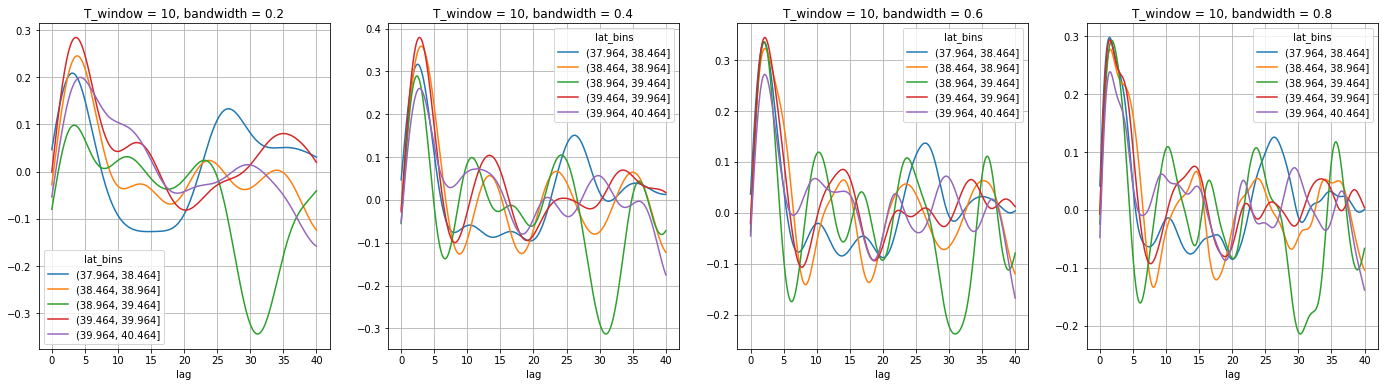

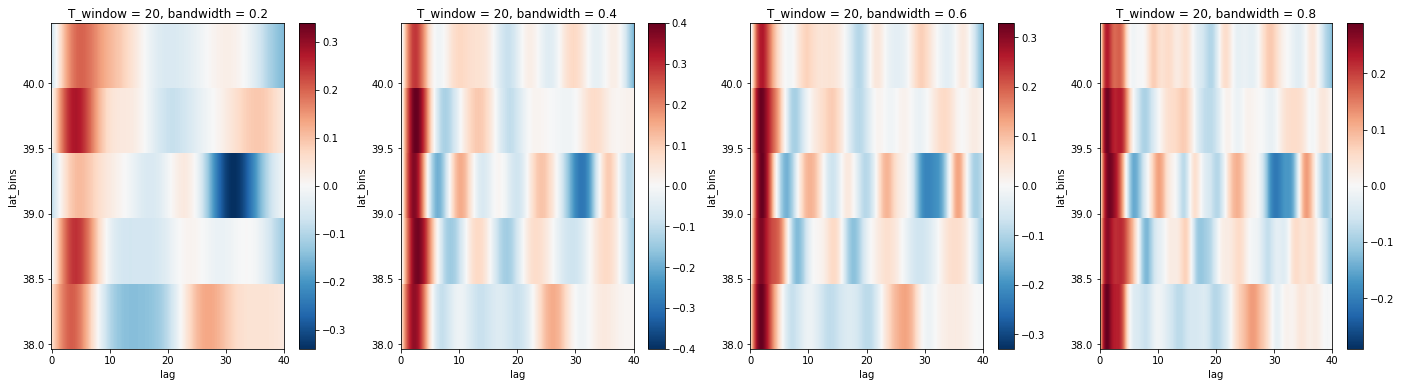

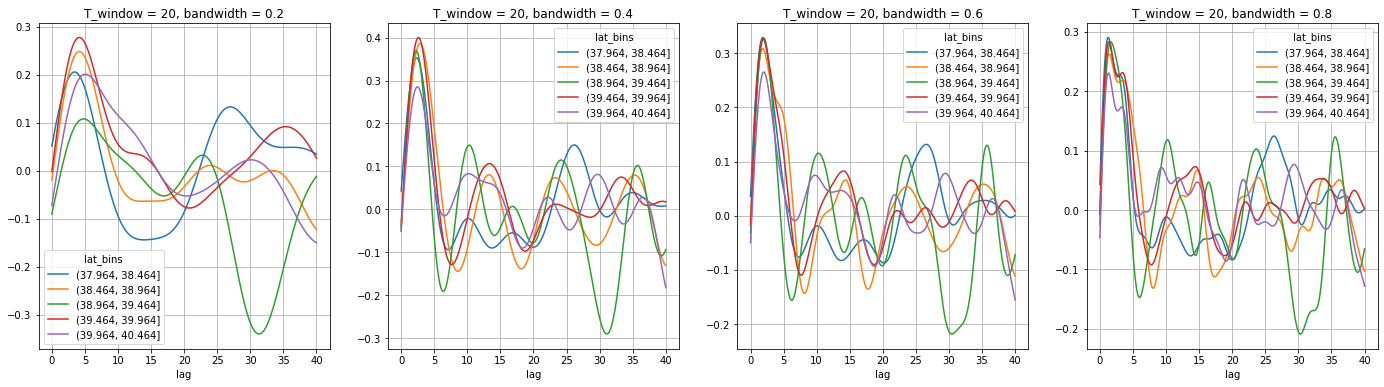

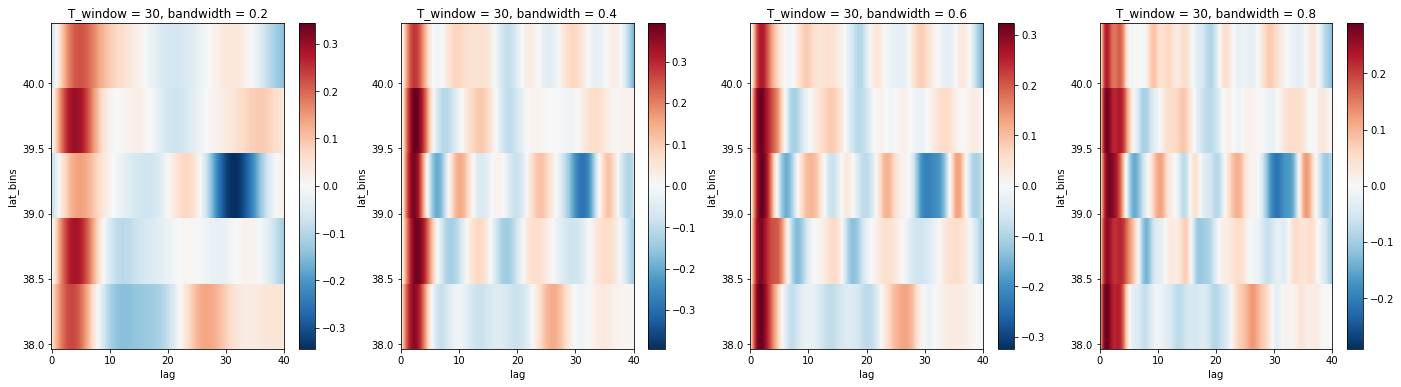

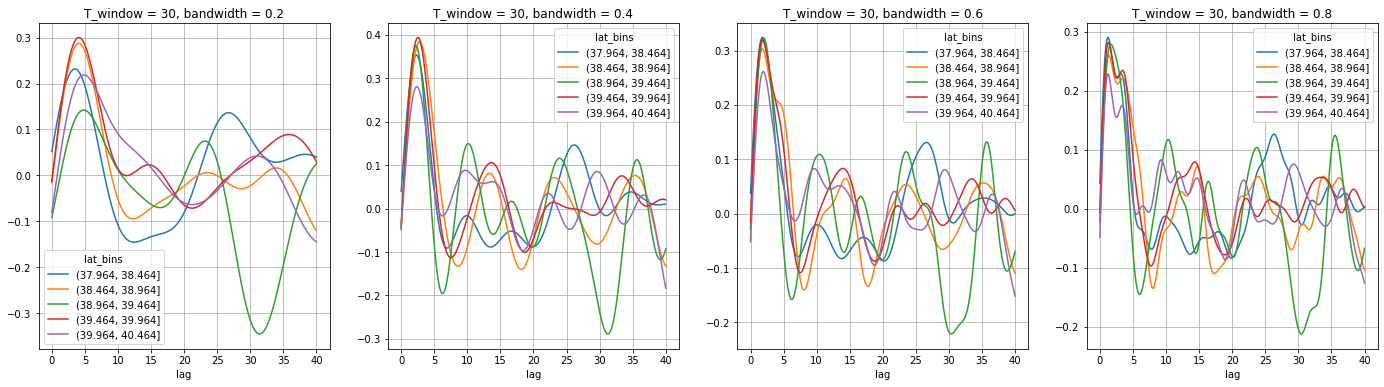

In [46]:
for Tw in _ds.T_window:
    fig,axs = plt.subplots(1,len(_ds.bandwidth),figsize=(6*len(_ds.bandwidth),6))
    for dband,ax in zip(_ds.bandwidth,axs):
        (_ds.ri.sel(T_window=Tw).mean(['lon_bins'])/_ds.rr.sel(T_window=Tw).mean(['lon_bins']).isel(lag=0)).sel(bandwidth=dband).plot(ax=ax)
    fig,axs = plt.subplots(1,len(_ds.bandwidth),figsize=(6*len(_ds.bandwidth),6))
    for dband,ax in zip(_ds.bandwidth,axs):
        (_ds.ri.sel(T_window=Tw).mean(['lon_bins'])/_ds.rr.sel(T_window=Tw).mean(['lon_bins']).isel(lag=0)).sel(bandwidth=dband).plot(ax=ax,hue='lat_bins')
        ax.grid()    

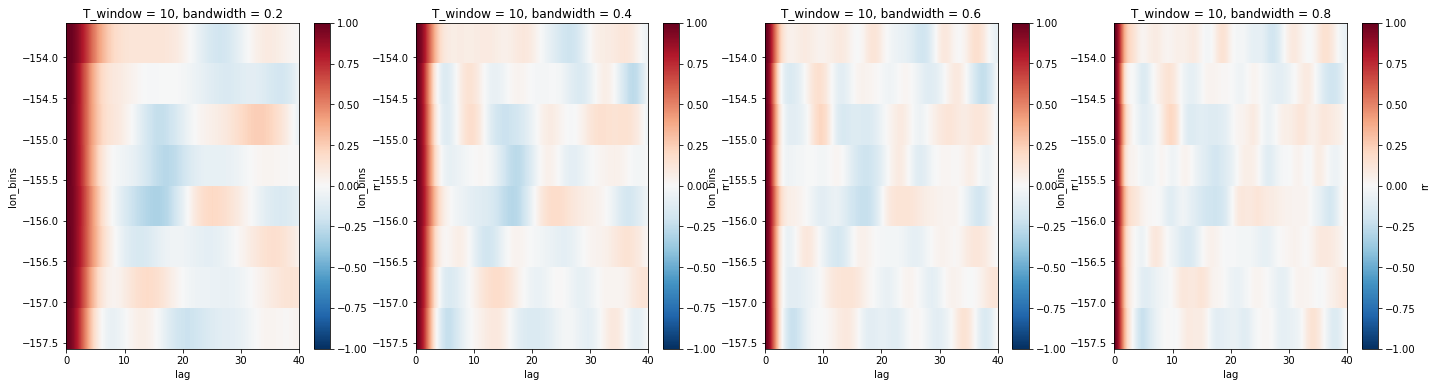

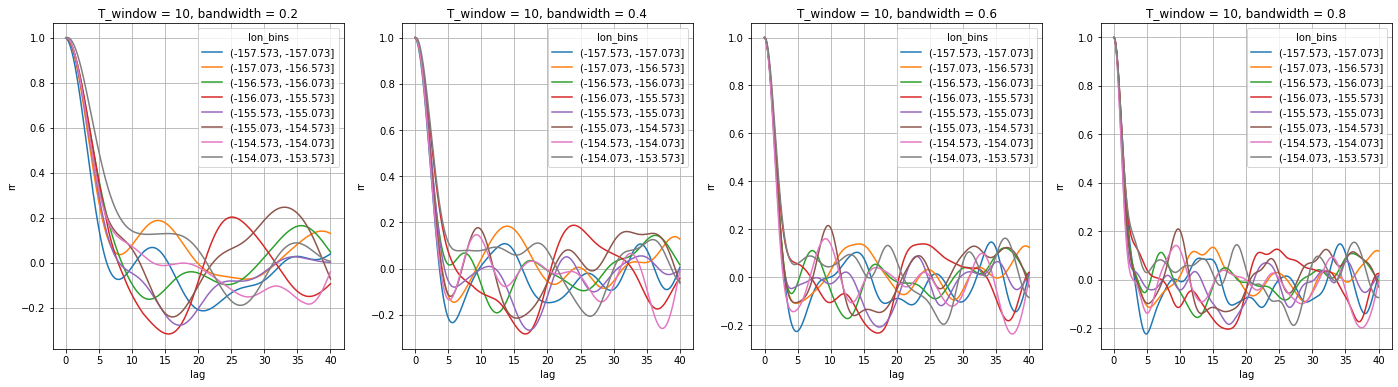

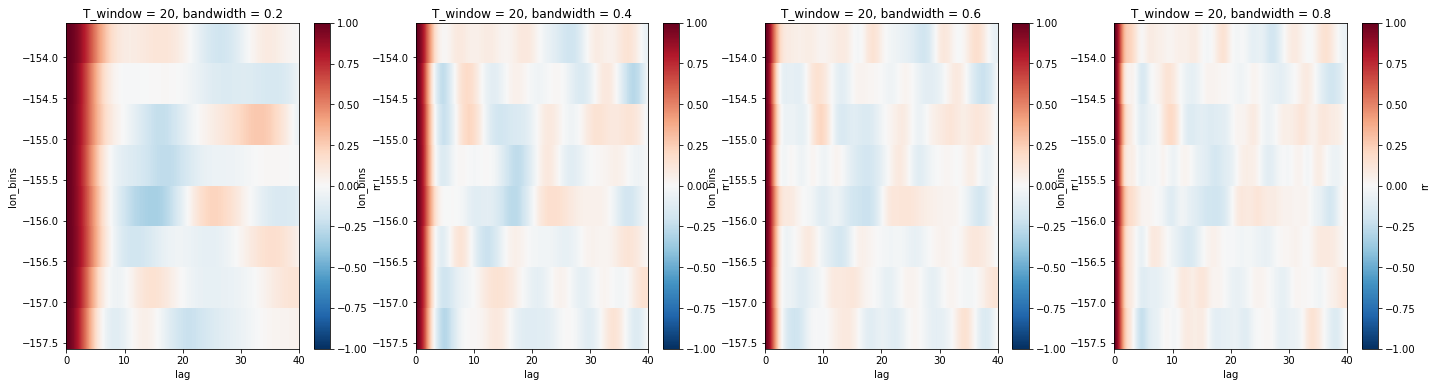

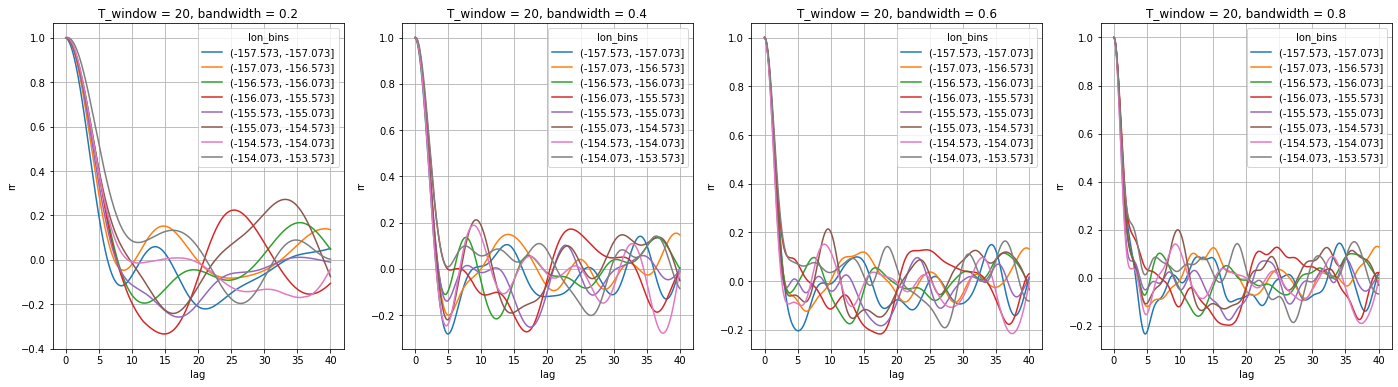

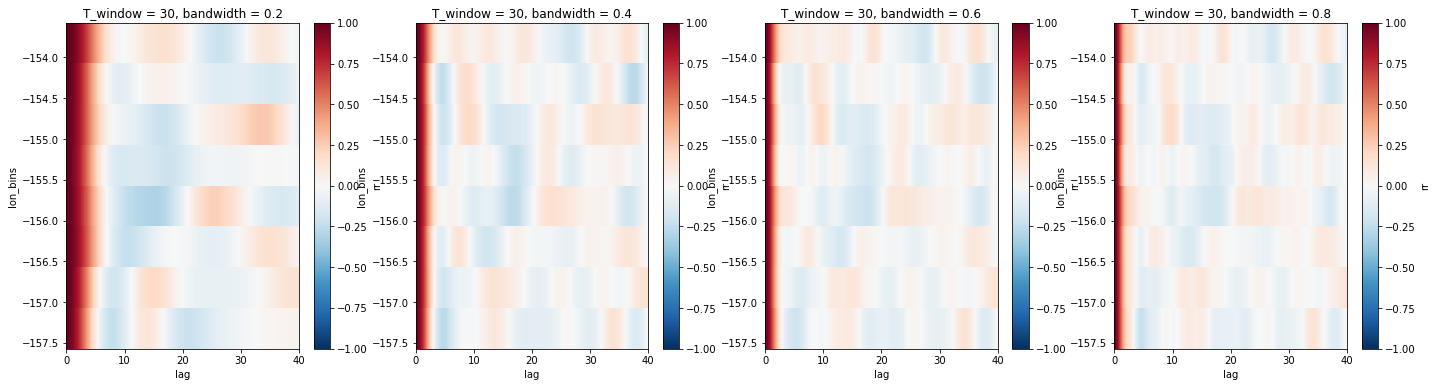

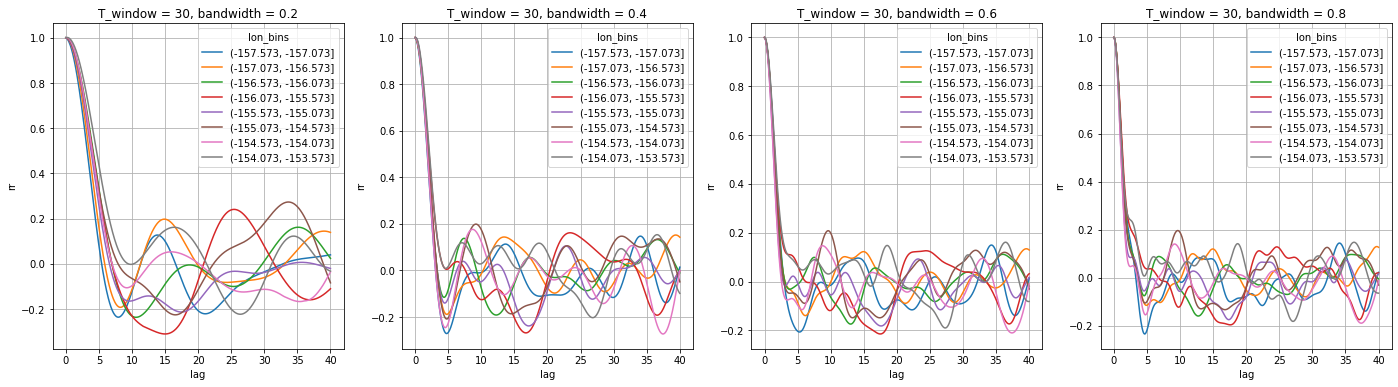

In [47]:
for Tw in _ds.T_window:
    fig,axs = plt.subplots(1,len(_ds.bandwidth),figsize=(6*len(_ds.bandwidth),6))
    for dband,ax in zip(_ds.bandwidth,axs):
        (_ds.rr.sel(T_window=Tw).mean(['lat_bins'])/_ds.rr.sel(T_window=Tw).mean(['lat_bins']).isel(lag=0)).sel(bandwidth=dband).plot(ax=ax)
    fig,axs = plt.subplots(1,len(_ds.bandwidth),figsize=(6*len(_ds.bandwidth),6))
    for dband,ax in zip(_ds.bandwidth,axs):
        (_ds.rr.sel(T_window=Tw).mean(['lat_bins'])/_ds.rr.sel(T_window=Tw).mean(['lat_bins']).isel(lag=0)).sel(bandwidth=dband).plot(ax=ax,hue='lon_bins')
        ax.grid()

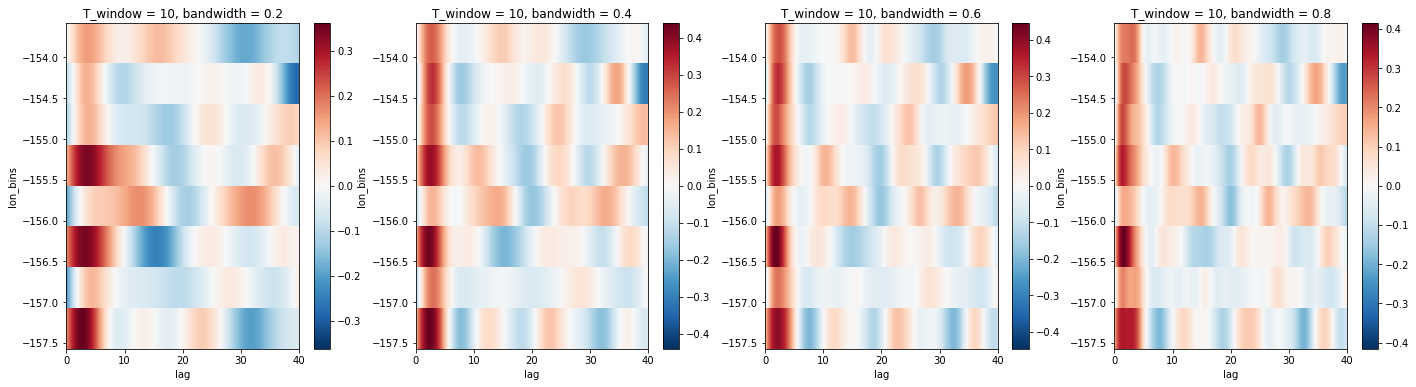

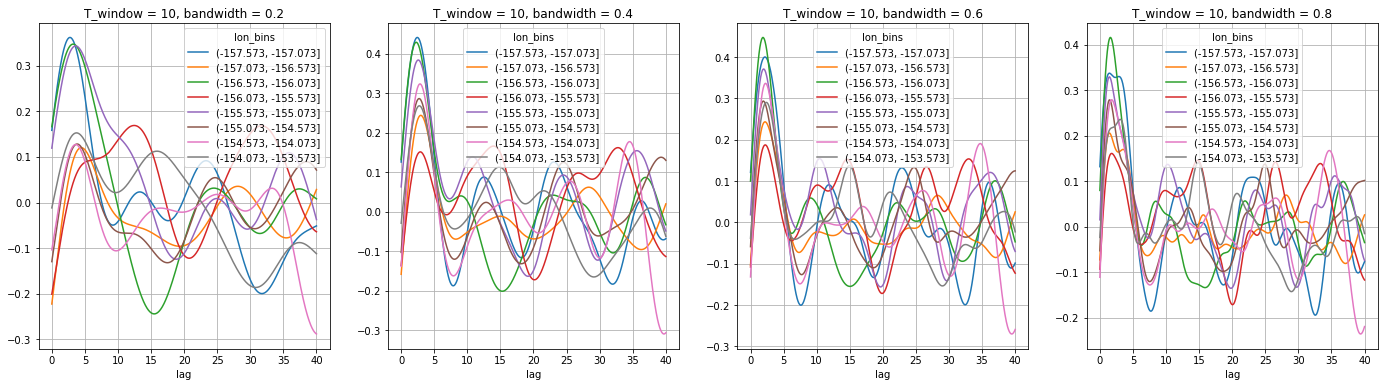

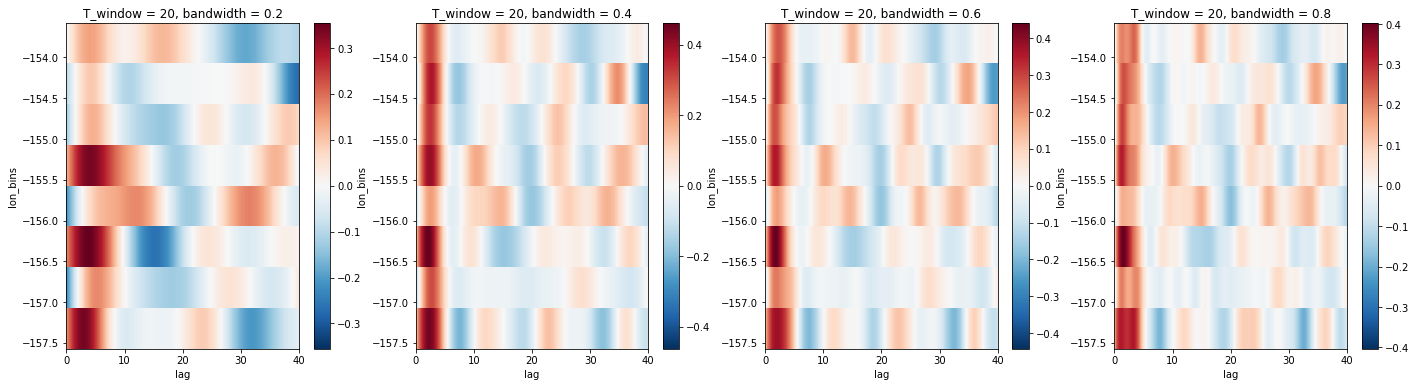

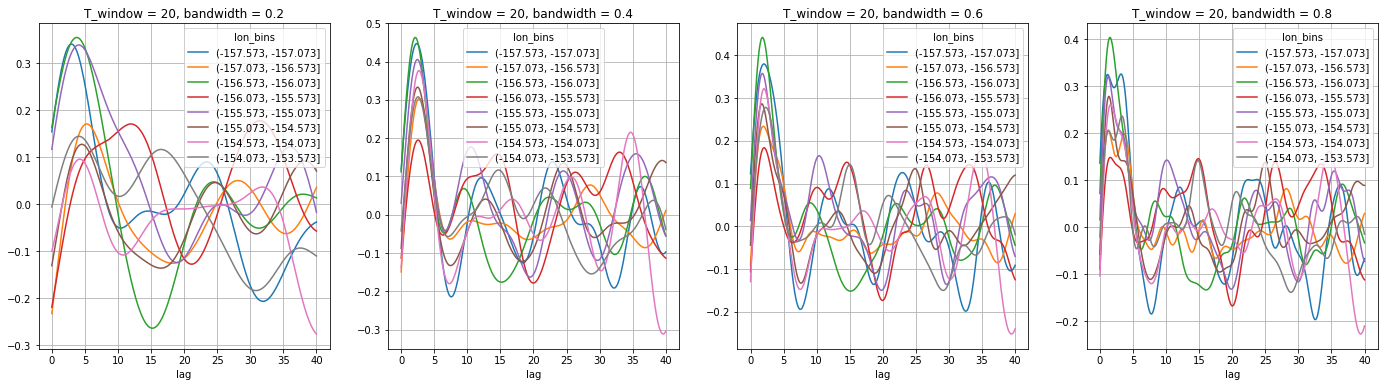

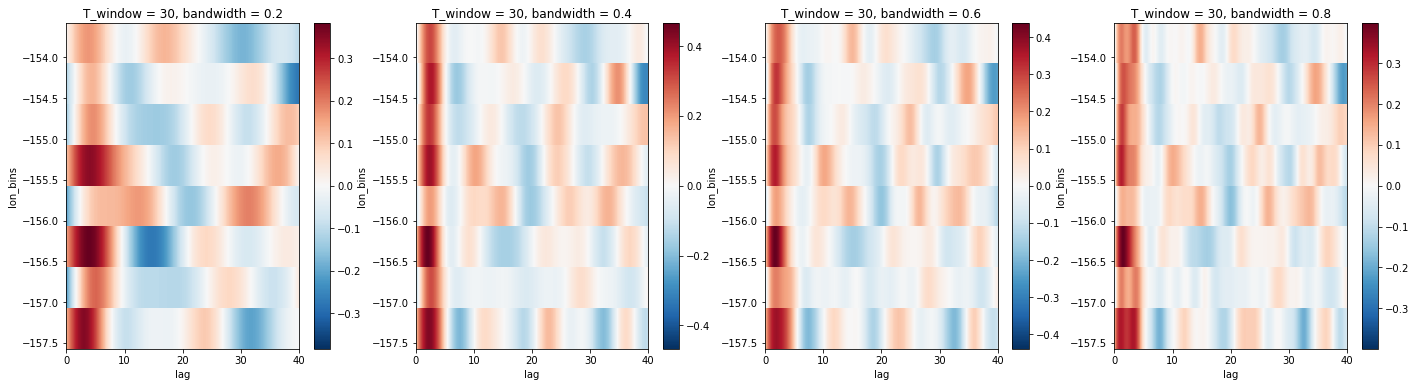

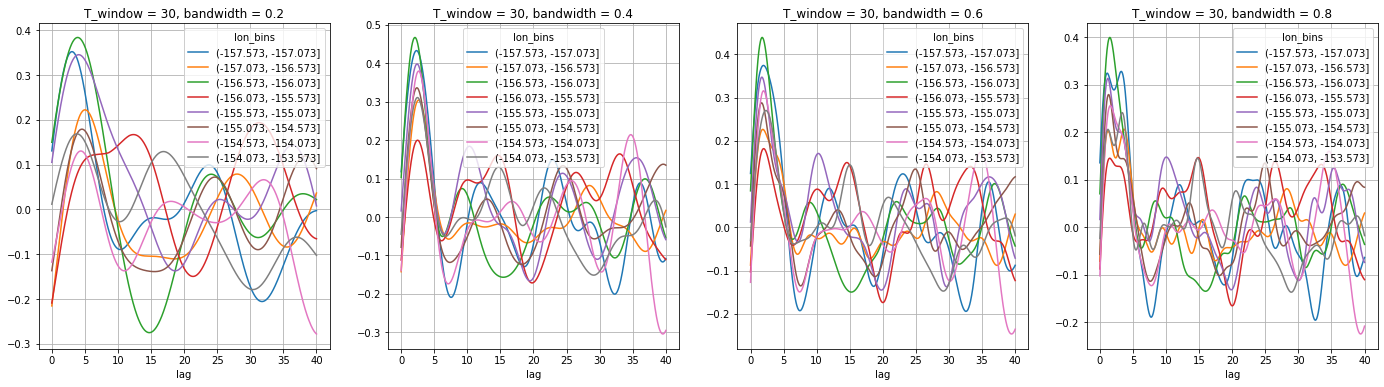

In [48]:
for Tw in _ds.T_window:
    fig,axs = plt.subplots(1,len(_ds.bandwidth),figsize=(6*len(_ds.bandwidth),6))
    for dband,ax in zip(_ds.bandwidth,axs):
        (_ds.ri.sel(T_window=Tw).mean(['lat_bins'])/_ds.rr.sel(T_window=Tw).mean(['lat_bins']).isel(lag=0)).sel(bandwidth=dband).plot(ax=ax)
    fig,axs = plt.subplots(1,len(_ds.bandwidth),figsize=(6*len(_ds.bandwidth),6))
    for dband,ax in zip(_ds.bandwidth,axs):
        (_ds.ri.sel(T_window=Tw).mean(['lat_bins'])/_ds.rr.sel(T_window=Tw).mean(['lat_bins']).isel(lag=0)).sel(bandwidth=dband).plot(ax=ax,hue='lon_bins')
        ax.grid()    

In [81]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
